In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import sympy as sp
import scipy as sc
import scipy.signal as signal
from   datetime import datetime, timedelta
import statsmodels.api as sm
import os
import matplotlib as mpl
import glob
import statsmodels.api as sm
from scipy.optimize import curve_fit
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime
from os.path import dirname, join as pjoin
import scipy.io as sio
from matplotlib import cm
import glob
import matplotlib.dates as mdates
from windrose import WindroseAxes
from windrose import WindAxes
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib import font_manager as fm
import cdsapi
from netCDF4 import Dataset, num2date
from pytz import timezone
import pytz
from pyproj import Proj
import mat73
import missingno as msno
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pylab as pl

plt.style.use('default')

In [2]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [3]:
# Funiciones 
def roundBy(x, base=10):
    return int(base * round(float(x)/base))

def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return lon, lat


def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Bathymetry

Already

In [5]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_200m"
## Lecutra de la batimetría
#-------------------------------------
delta = 200                                           # Tamaño de la grilla 
x = np.array ([404758.9787 + i*delta for i in range(203)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1368354.4849 + i*delta for i in range (208)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\idw_200m.txt',skip_header = 6))
z[z == -9999] = np.nan # Z donde es tierra

kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()

In [6]:
##----------Lectura de la lína de costa
data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
mat_fname = pjoin(data_dir, 'linea_Costa.mat')     # Econtrar el archivo
data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
Variables = sorted(data_mat.keys())               # Variables ordenadas Alfa-numericamente 
Variables
xlc = np.array(data_mat['data'][0][0][0])
ylc = np.array(data_mat['data'][0][0][1])
lc=np.column_stack((xlc,ylc))

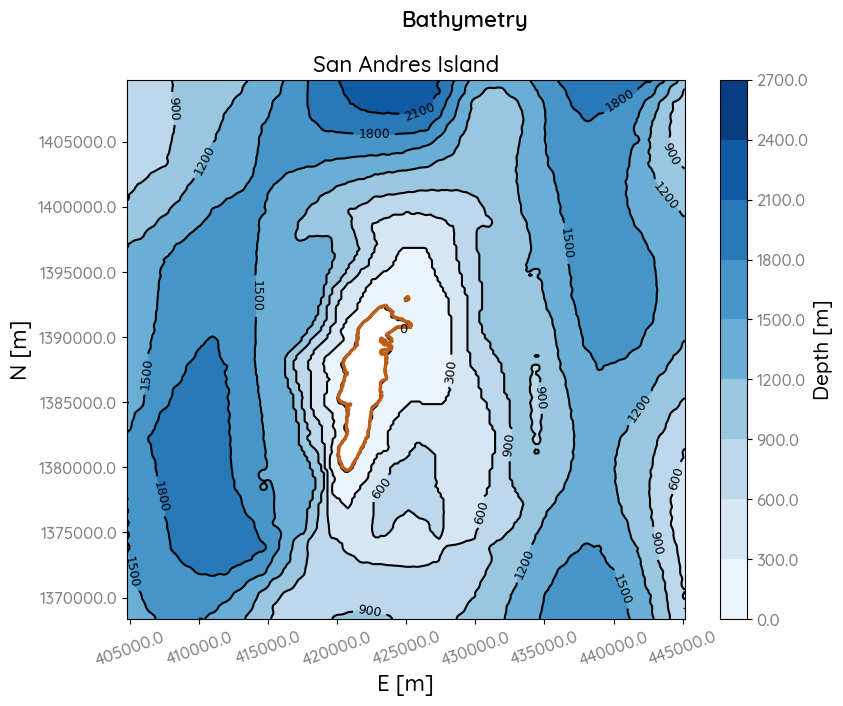

In [7]:
fig, ax = plt.subplots(figsize = (9,7))
colormap = cm.coolwarm
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,3000,300),cmap='Blues')
cb=plt.colorbar(pc)
# a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,3000,300)),colors="rosybrown",\
#                linewidths=1.5)
a = ax.contour(x_new, y_new, z_new,colors="k",levels=list(np.arange(0,3000,300)),\
                linewidths=1.5)
label = plt.clabel(a, fontsize=9, inline=1, fmt = '%1.0f', colors="k")
# plt.clabel(a, fontsize=9, inline=1,fmt='%2.1f',colors='k')
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
ax.plot(lc[:,0], lc[:,1], "-k", lw=2)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Depth [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
fig.suptitle("Bathymetry", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('San Andres Island',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# Cunado los xticklabels son fechas:
# for label in ax.get_xticklabels():
#     label.set_fontproperties(prop_1)
#     label.set_color('gray')
#     label.set_size(12)
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9)
# ax.set_title('Localización: 81.500°W - 12.670°N',size = 18)
# ax.legend(loc = 4)
# ax.set_xticks(rotation=30)
plt.xticks(rotation = 20)
plt.grid(False)

# Coordinate Z- model

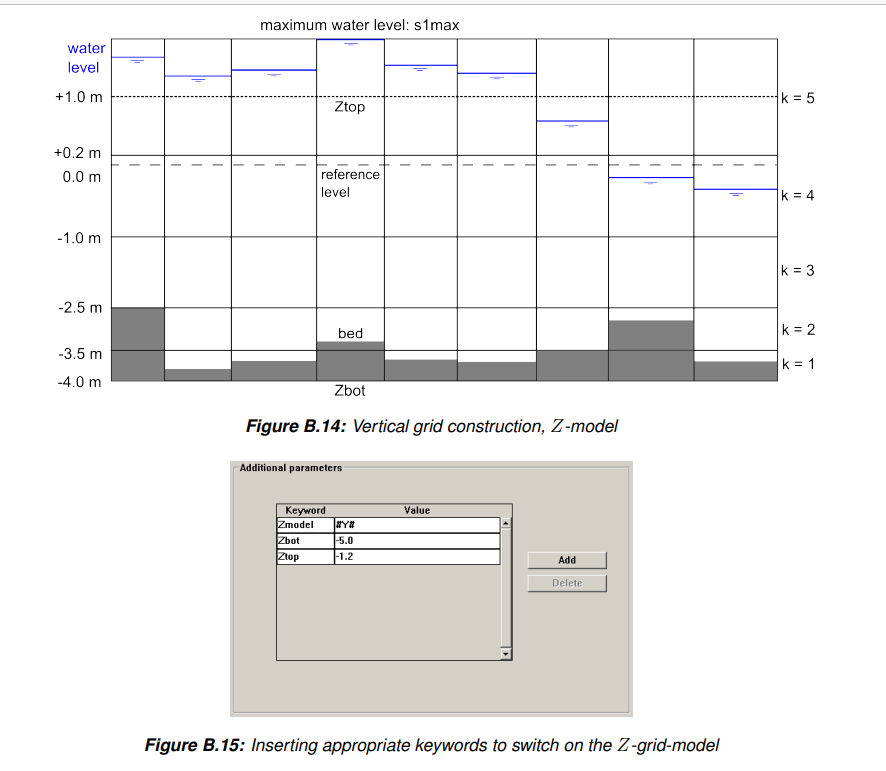

# Initial conditions

Now, uniform values, before enter a map file

# Boundary conditions

In [8]:
n_capas = int(input('Ingrese el numero de capas a modelar',))

## Flow velocity and water level (Riemman conditions)

In [9]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data = Dataset(path+'\Hycom_oct21_nov15_2021_6.nc','r')
data_vel = Dataset(path+'\Hycom_oct21_nov15_2021_6_v_u.nc','r')
print(data_vel.variables)

{'latitude': <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (25,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (7,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: hours since 2000-01-01 00:00:00
    time_origin: 2000-01-01 00:00:00
    calendar: gregorian
unlimited dimensions: 
current shape = (200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'depth': <class 'netCDF4._netCDF4.Variable'>
float64 depth(depth)
    units: m
unlimited dimensions: 
current shape = (19,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'water_u': <class 'netCDF4._netCDF4.Variable'>
float64 water_u(time, depth, latitude, longitude)
    units: m/s
    mi

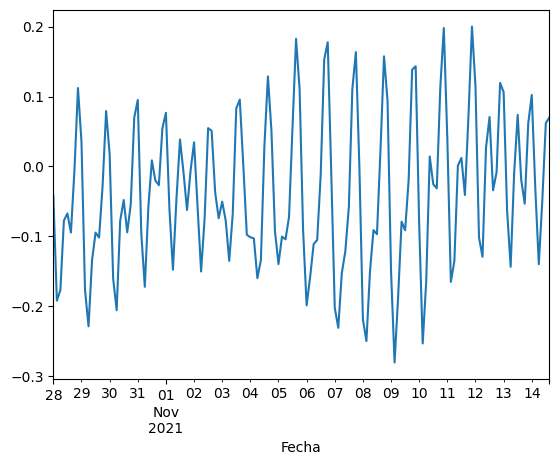

In [10]:
df_ws = pd.read_csv(path+'\ISA_WATER_LEVEL_2021.txt', sep='\t')
df_ws['Fecha'] = pd.to_datetime(df_ws['Fecha'], format="%d/%m/%Y %H:%M:%S")
df_ws['Nivel'] = df_ws['Nivel'] - df_ws['Nivel'].mean()
df_ws.set_index('Fecha', inplace= True)
df_ws.head(5)

# ----------------------- Resample de la serie cada 3 horas -------------------------
ws = pd.Series(df_ws['2021-10-28 00:00:00':'2021-11-14 15:00:00'].Nivel)
ws = ws.resample('180min').mean()
ws.plot();

,minutes,A,B
137,24660.0,-0.030762,-0.024609
138,24840.0,-0.139981,-0.111985
139,25020.0,-0.048603,-0.038883
140,25200.0,0.062163,0.049731
141,25380.0,0.069991,0.055993


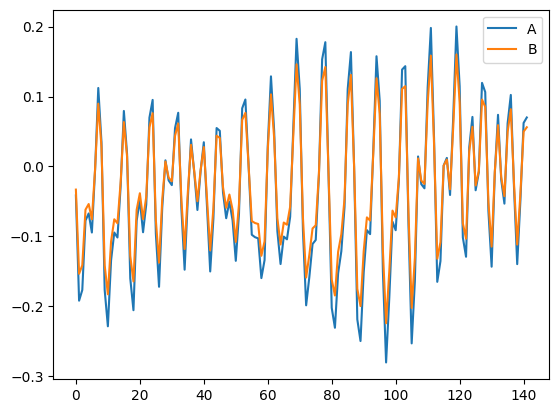

In [11]:
df_wl = pd.DataFrame(ws)
df_wl['minutes'] = np.array([(df_wl.index[i]-df_wl.index[0]).days*1440 + (df_wl.index[i]-df_wl.index[0]).seconds/60 for i in range (0, len(df_wl.index))])
df_wl['B'] = df_wl.Nivel*0.8
df_wl = df_wl.rename(columns={'Nivel':'A'}).reset_index(drop=True)
df_wl = df_wl[['minutes', 'A', 'B']]
df_wl[['A','B']].plot()
df_wl.tail(5)

In [12]:
# path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
# name_file = 'eats_water_level.bct'
# np.savetxt(path+'/'+name_file, df_wl.values, delimiter=' ', fmt = "%+15.7e")

In [13]:
# # Descomposición de la marea 
# my_tide = Tide.decompose(ws, ws.index)

# constituent = [c.name for c in my_tide.model['constituent']]
# df_constituent = pd.DataFrame(my_tide.model, index = constituent).drop('constituent',axis=1)
# df_constituent.reset_index(inplace=True)
# df_const_tidal= df_constituent.sort_values('amplitude', ascending = False).rename(columns={'index':'ID'})
# df_const_tidal



In [14]:
# Guardar archivo de marea
# path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
# f =open(path+'\Astro_tide.bca','w')
# for i in range (len(df_const_tidal.ID)):
#     a = f'{df_const_tidal.iloc[i].ID:<17}'
#     b = f'{df_const_tidal.iloc[i].amplitude:>8}'
#     c = f'{df_const_tidal.iloc[i].phase:>6}'
#     print(a+' '+b+' '+c)
#     f.write(a+' '+b+' '+c+'\n')
# f.close()

In [15]:
# LLamar los datos de la base de datos Hycom
lat = np.array(data_vel.variables['latitude'][:])
lon = np.array(data_vel.variables['longitude'][:])
nctime = np.array(data_vel.variables['time'][:])
t_unit = data_vel.variables['time'].units
t_cal = data_vel.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])

#------ Cambiar referencia de tiempo a utm-----------------------------------
# Cambiar la zona horaria utc 0 a utc -5
# utc = pytz.utc
# col_zone = timezone('America/Bogota')
# time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
# loc_co =np.array([i.astimezone(col_zone) for i in time2])
# time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

#-----------Variables-------------------------------------
depth = np.array(data_vel.variables['depth'][:]) 
ws = np.array(data.variables['surf_el'][:])
u = np.array(data_vel.variables['water_u'][:])
u[u==-30000] = np.nan
v = np.array(data_vel.variables['water_v'][:])
v[v==-30000] = np.nan

len(ws), u.shape, v.shape, depth.shape, lat.shape, lon.shape

(200, (200, 19, 25, 7), (200, 19, 25, 7), (19,), (25,), (7,))

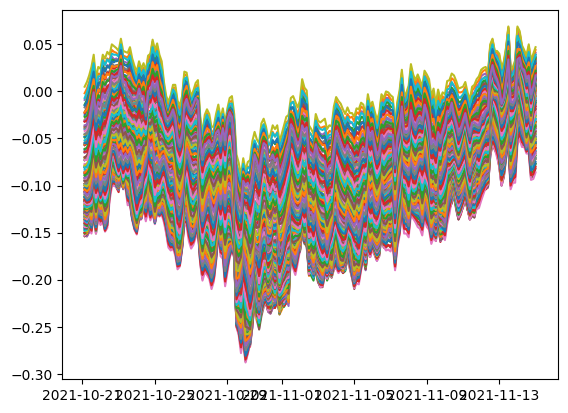

In [16]:
for i in range(len(lat)):
    for j in range(len(lon)): 
        plt.plot(time, ws[:,i,j])

In [17]:
print(lat[1] - lat[0])
print(lon[1] - lon[0])

0.039999961853027344
0.08001708984375


In [18]:
lon_min, lat_min = coord_wgs (np.nanmin(x_new),np.nanmin(y_new))
360+lon_min, lat_min
lon_max, lat_max = coord_wgs (np.nanmax(x_new),np.nanmax(y_new))
360+lon_max, lat_max

(278.49478255337556, 12.751914259554704)

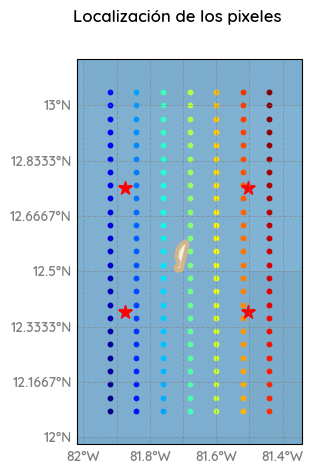

In [19]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
i = 0
for loni in (lon):
    for lati in (lat):
        ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
        i = i +1
# i = 0
# for loni, lati in zip (lon, lat):
#     ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(loni)+'-'+str(lati), color = colors_cm[i])
#     i=i+1

ax1.scatter(360+lon_min, lat_min, marker = "*", s=10**2, color = 'red')
ax1.scatter(360+lon_max, lat_max, marker = "*", s=10**2, color = 'red')
ax1.scatter(360+lon_min, lat_max, marker = "*", s=10**2, color = 'red')
ax1.scatter(360+lon_max, lat_min, marker = "*", s=10**2, color = 'red')


ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')




#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

prop2.set_size(6)
# _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
#           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12,fontproperties=prop2);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [20]:
# Encontrar los índices más cercanos a los extramos de la grilla de computo
ind_max_lat_bd = min_ind(value = lat_max, vector = lat, delta = 0.04)
ind_min_lat_bd = min_ind(value = lat_min, vector = lat, delta = 0.04)
ind_max_lon_bd = min_ind(value = lon_max + 360, vector = lon, delta =0.08)
ind_min_lon_bd = min_ind(value = lon_min + 360, vector = lon, delta =0.08)

ind_mean_lat_bd = min_ind(value = ((lat_max - lat_min)/2)+lat_min , vector = lat, delta = 0.04)
ind_mean_lon_bd = min_ind(value = (((lon_max+360) - (lon_min+360))/2)+(lon_min+360) , vector = lon, delta = 0.04)


lat_max_bd, lat_min_bd = lat[ind_max_lat_bd],  lat[ind_min_lat_bd]
lat_mean_bd = lat[ind_mean_lat_bd]
lon_max_bd, lon_min_bd = lon[ind_max_lon_bd], lon[ind_min_lon_bd]
lon_mean_bd = lon[ind_mean_lon_bd]

Indice: 17 , Valor: 12.760000228881836 , Valor real: 12.751914259554704
Indice: 8 , Valor: 12.399999618530273 , Valor real: 12.376604643559318
**********ERROR************
Indice: 5 , Valor: 278.47998046875 , Valor real: 278.49478255337556
Indice: 1 , Valor: 278.1600341796875 , Valor real: 278.12389429615087
Indice: 13 , Valor: 12.600000381469727 , Valor real: 12.56425945155701
Indice: 3 , Valor: 278.32000732421875 , Valor real: 278.3093384247632


,minutes,A,B
137,24660.0,0.031,-0.001
138,24840.0,0.015,-0.017
139,25020.0,0.006,-0.026
140,25200.0,-0.008,-0.040
141,25380.0,-0.003,-0.031


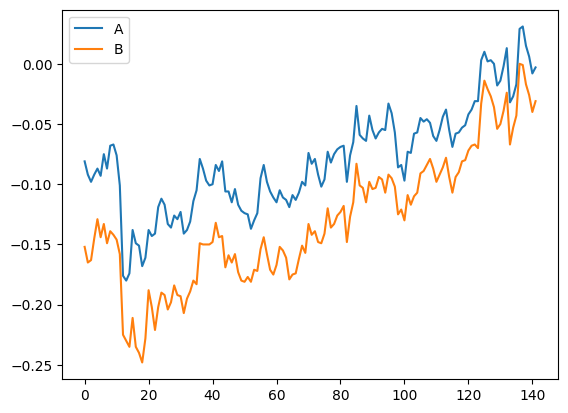

In [21]:
df_ws_hycom = pd.DataFrame({'A':ws[:,ind_max_lat_bd, ind_max_lon_bd],'B':ws[:,ind_min_lat_bd, ind_max_lon_bd]}, index = time)
df_ws_hycom = df_ws_hycom['2021-10-28 00:00:00':'2021-11-14 15:00:00']
df_ws_hycom['minutes'] = np.array([(df_ws_hycom.index[i]-df_ws_hycom.index[0]).days*1440 + (df_ws_hycom.index[i]-df_ws_hycom.index[0]).seconds/60 for i in range (0, len(df_ws_hycom.index))])
df_ws_hycom = df_ws_hycom[['minutes', 'A', 'B']].reset_index(drop=True)

df_ws_hycom[['A', 'B']].plot()
df_ws_hycom.tail(5)

In [22]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'eats_water_level.bct'
np.savetxt(path+'/'+name_file, df_ws_hycom.values, delimiter=' ', fmt = "%+15.7e")

,minutes,A,B
137,24660.0,0.031,0.010
138,24840.0,0.015,-0.002
139,25020.0,0.006,-0.004
140,25200.0,-0.008,-0.013
141,25380.0,-0.003,0.000


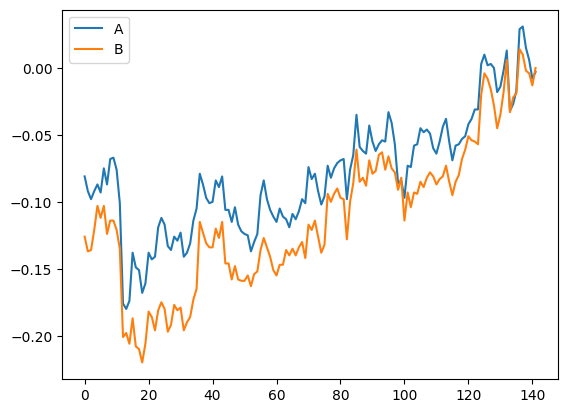

In [23]:
df_ws_hycom = pd.DataFrame({'A':ws[:,ind_max_lat_bd, ind_max_lon_bd],'B':ws[:,ind_min_lat_bd, ind_min_lon_bd]}, index = time)
df_ws_hycom = df_ws_hycom['2021-10-28 00:00:00':'2021-11-14 15:00:00']
df_ws_hycom['minutes'] = np.array([(df_ws_hycom.index[i]-df_ws_hycom.index[0]).days*1440 + (df_ws_hycom.index[i]-df_ws_hycom.index[0]).seconds/60 for i in range (0, len(df_ws_hycom.index))])
df_ws_hycom = df_ws_hycom[['minutes', 'A', 'B']].reset_index(drop=True)

df_ws_hycom[['A', 'B']].plot()
df_ws_hycom.tail(5)

In [24]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'west_water_level.bct'
np.savetxt(path+'/'+name_file, df_ws_hycom.values, delimiter=' ', fmt = "%+15.7e")

For modelling the region outside the computational domain, incident waves should be known and are prescribed at the open boundaries. To reduce the reflections at the open boundaries a so-called weakly reflecting boundary condition may be applied. This boundary condition is derived using the Riemann invariants of the linearized shallow water equations without Coriolis and bottom friction (Verboom and Slob, 1984).

$f(t)=U+\zeta\sqrt{\frac{g}{d}}$

where $U$ in m/s is depth-averaged velocity in $x$ or ξ direction, $\zeta$ in m is water level above some horizontal plane of reference (datum),  $d$ an $g$ are depth below some horizontal plane of reference (datum) and acceleration due to gravity in m and m/s respectively.

In [22]:
# Definicion de las funciones Riemann
def uriemman(u, ws, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd, inout):
    """
    ------------input------------------------
    u: arreglo de las velocidades en la componente u
    ws: serie de la superficie de nivel del mar
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    inou: String "in" "out" la onda entra o sale
    
    ------------output----------------------------
    ft: serie de riemman para la profundidad deseada 
    
    """
    # ws = ws # ---> Cuando tomo la serie de marea como nivel del mar
    ws = ws[:,np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    g = 9.81 
    u_mean = np.nanmean(u[:,np.where(depth_s==depth_bd)[0][0]:,\
                          np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]], axis =1)
    if depth_bd == 0:
        depth_bd = 1
    else: 
        depth_bd = depth_bd
    
    if inout == 'in':
        ft = u_mean + ws*(np.sqrt(g/depth_bd))
    elif inout == 'out':
        ft = u_mean - ws*(np.sqrt(g/depth_bd))
    return ft

def vriemman(v, ws, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd, inout):
    """
    ------------input------------------------
    v: arreglo de las velocidades en la componente v
    ws: serie de la superficie de nivel del mar
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    inou: String "in" "out" la onda entra o sale
    ------------output----------------------------
    ft: serie de riemman para la profundidad deseada 
    
    """
    # ws = ws # ---> Cuando tomo la serie de marea como nivel del mar
    ws = ws[:,np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    g = 9.81 
    v_mean = np.nanmean(v[:,np.where(depth_s==depth_bd)[0][0]:,\
                          np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]], axis =1)
    if depth_bd == 0:
        depth_bd = 1
    else: 
        depth_bd = depth_bd

    if inout == 'in':
        ft = v_mean + ws*(np.sqrt(g/depth_bd))
    elif inout == 'out':
        ft = v_mean - ws*(np.sqrt(g/depth_bd))
    
    return ft

In [23]:
# depth_layer = np.array([0, 8, 20, 40, 50, 70, 90, 125,300,800])
# depth_layer

# --------------Condicion para una grilla en Z-------------------------
#depth_layer = depth[::-1] # Recordar que las capas son inversas

##---------------Condición para una grulla sigma-----------------------
# depth_layer = depth

# ##----------------Para una capa-----------------------
depth_layer = [depth[0]]
depth_layer

[0.0]

## LOS PORCENTAJES DE LOS ESPESORES DE LAS CAPAS NO SON ACUMULADOS 

Por lo tanto para obtener estos valores medidmos desde la superficie `[0, 20, 40, 70, 90, 125,200, 300, 600, 800]`, como son acumulados, se debe descumular 
ya que la capa superficial se mueve desde la superficie hacia el fondo y el espesor es la difencia entre la siguiente capa

In [24]:
A = [0.05, 0.11, 0.16 , 0.16, 0.32, 0.4, 0.4, 0.4, 0.8, 0.8, 1.4, 3, 4, 4, 8, 18, 18, 20, 20]
print(sum(A)-100)
layers_thiknes = [i*2400/100 for i in A]
print(layers_thiknes)
print(np.cumsum(np.array(layers_thiknes)))

0.0
[1.2, 2.64, 3.84, 3.84, 7.68, 9.6, 9.6, 9.6, 19.2, 19.2, 33.6, 72.0, 96.0, 96.0, 192.0, 432.0, 432.0, 480.0, 480.0]
[1.200e+00 3.840e+00 7.680e+00 1.152e+01 1.920e+01 2.880e+01 3.840e+01
 4.800e+01 6.720e+01 8.640e+01 1.200e+02 1.920e+02 2.880e+02 3.840e+02
 5.760e+02 1.008e+03 1.440e+03 1.920e+03 2.400e+03]


In [25]:
# Time split
date_ini = datetime(2021,10,28,0) # Fechas inicial de modelación
date_fin = datetime(2021,11,14,18,0) # Fechas final de modelación
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])

u_split = u[ind_ini_fin[0]:ind_ini_fin[1],:,:]
v_split = v[ind_ini_fin[0]:ind_ini_fin[1],:,:]
ws_split = ws[ind_ini_fin[0]:ind_ini_fin[1],:,:]

<AxesSubplot:>

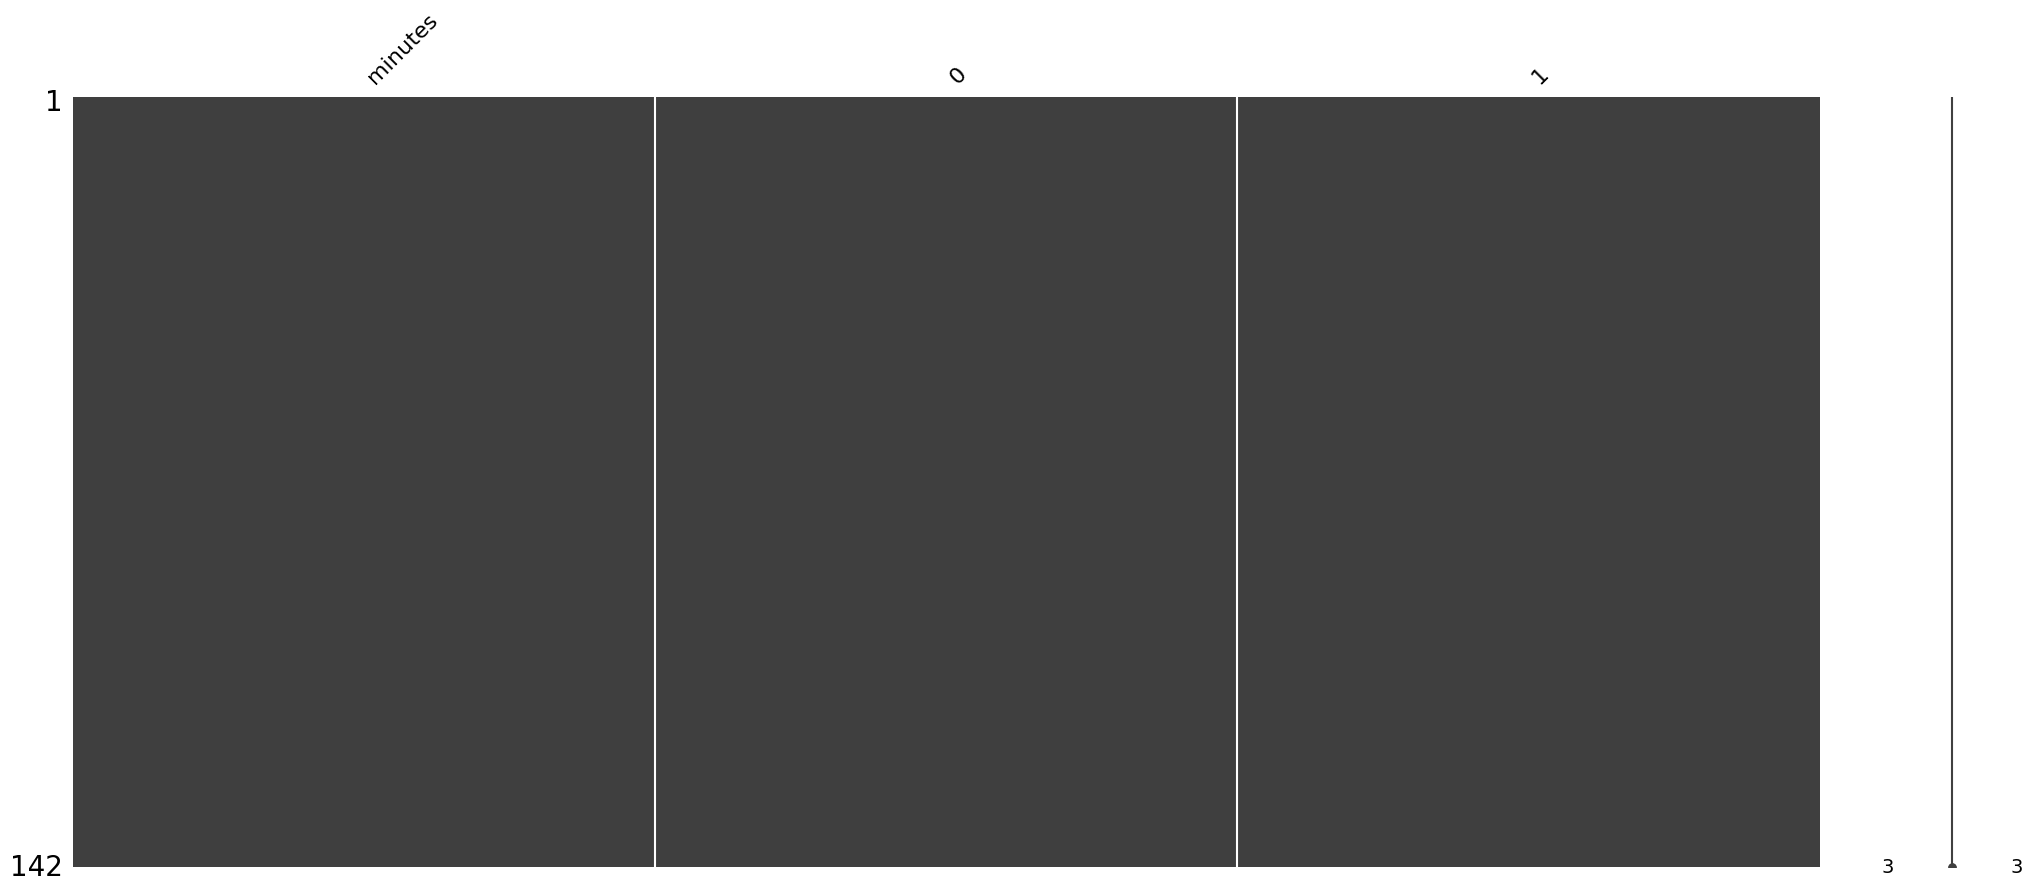

In [26]:
# Oeste
#------------ A ---------------------------------
dic = {}
for j, h in enumerate (depth_layer):
    ft = uriemman(u_split, ws_split ,depth, h, lat, lat_mean_bd, lon,lon_min_bd, inout='out')
    dic.update({j:ft})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    ft = uriemman(u_split, ws_split ,depth, h, lat, lat_max_bd, lon,lon_min_bd, inout='out')
    dic.update({n_capas+j:ft})
    
df_oeste = pd.DataFrame(dic)
df_oeste.insert(loc= 0, column = 'minutes', value = minutes)

# df_oeste[1] = df_oeste[2]+0.0001
# df_oeste[0] = df_oeste[1]+0.0001

# df_oeste[20] = df_oeste[22]
# df_oeste[19] = df_oeste[21]
msno.matrix(df_oeste)

In [26]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'west_boundary.bct'
np.savetxt(path+'/'+name_file, df_oeste.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

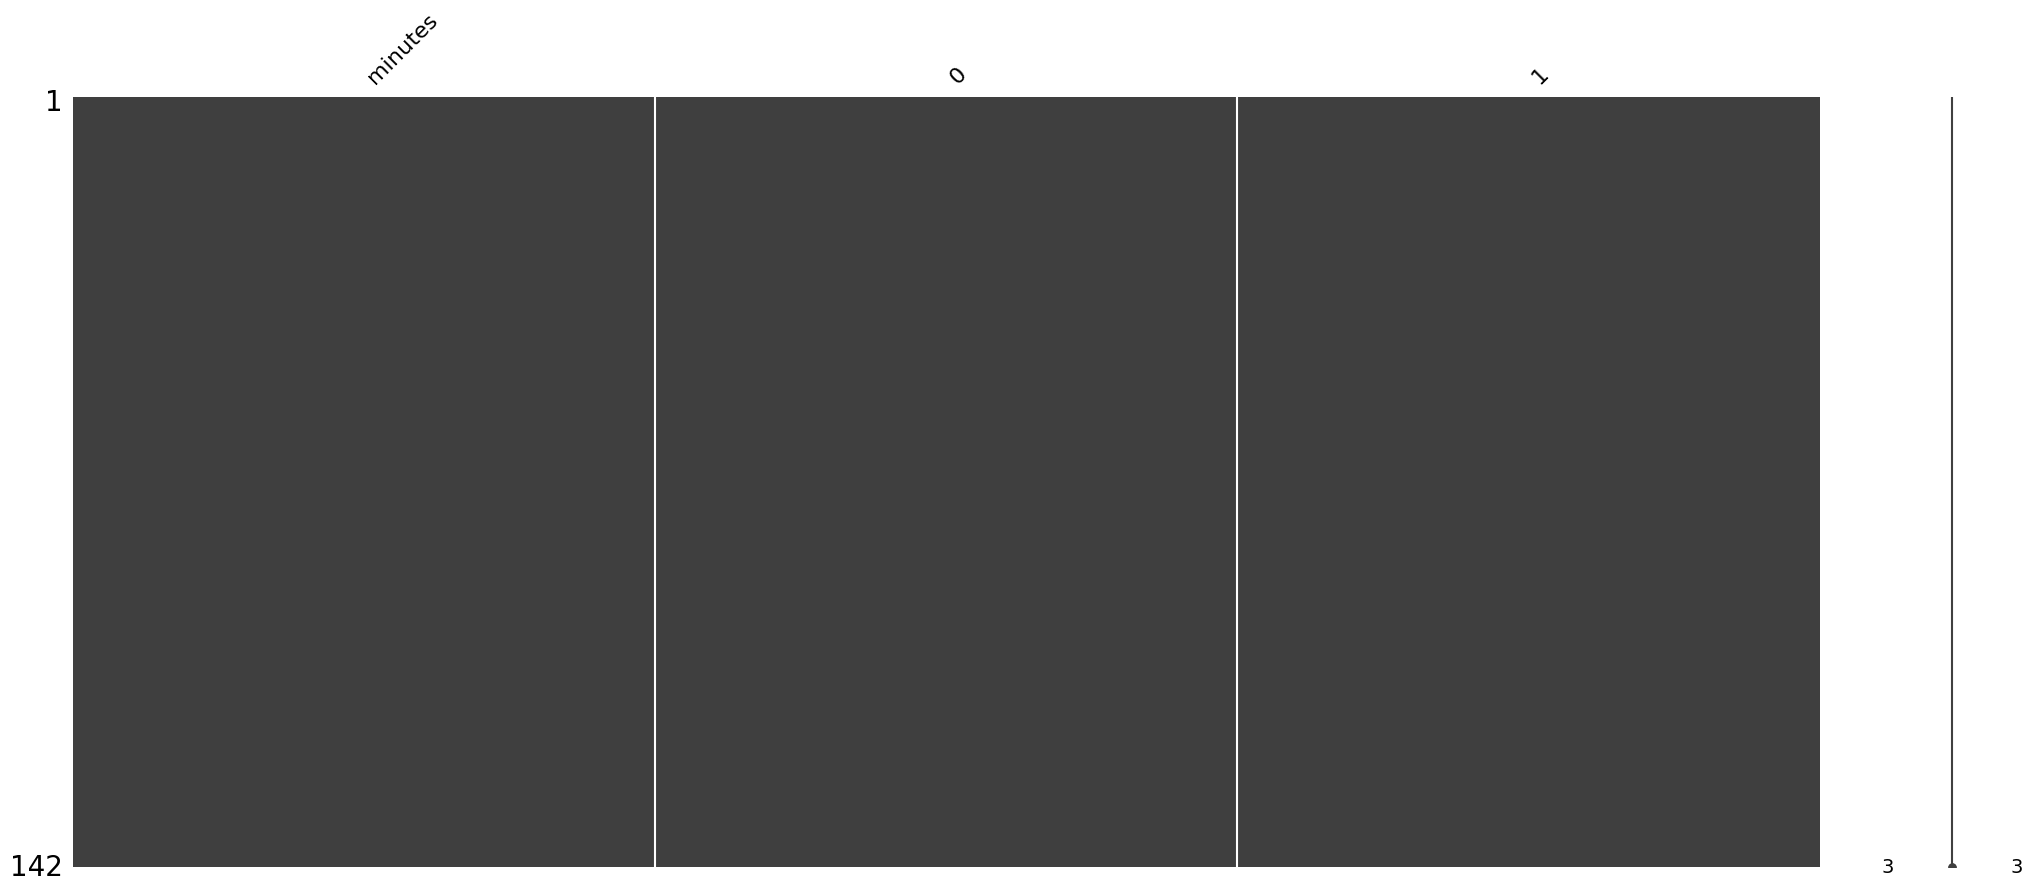

In [42]:
# Este ----> corresponde a nivel del mar 
#------------ A ---------------------------------
dic = {}
for j, h in enumerate (depth_layer):
    ft = uriemman(u_split, ws_split,depth, h, lat, lat_max_bd, lon,lon_max_bd,inout='in')
    dic.update({j:ft})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    ft = uriemman(u_split, ws_split,depth, h, lat, lat_mean_bd, lon,lon_max_bd,inout='in')
    dic.update({n_capas+j:ft})
    
df_este = pd.DataFrame(dic)
df_este.insert(loc= 0, column = 'minutes', value = minutes)

# df_este[1] = df_este[2]+0.0001
# df_este[0] = df_este[1]+0.0001

# df_este[20] = df_este[22]
# df_este[19] = df_este[21]
msno.matrix(df_este)

In [43]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'est_boundary.bct'
np.savetxt(path+'/'+name_file, df_este.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

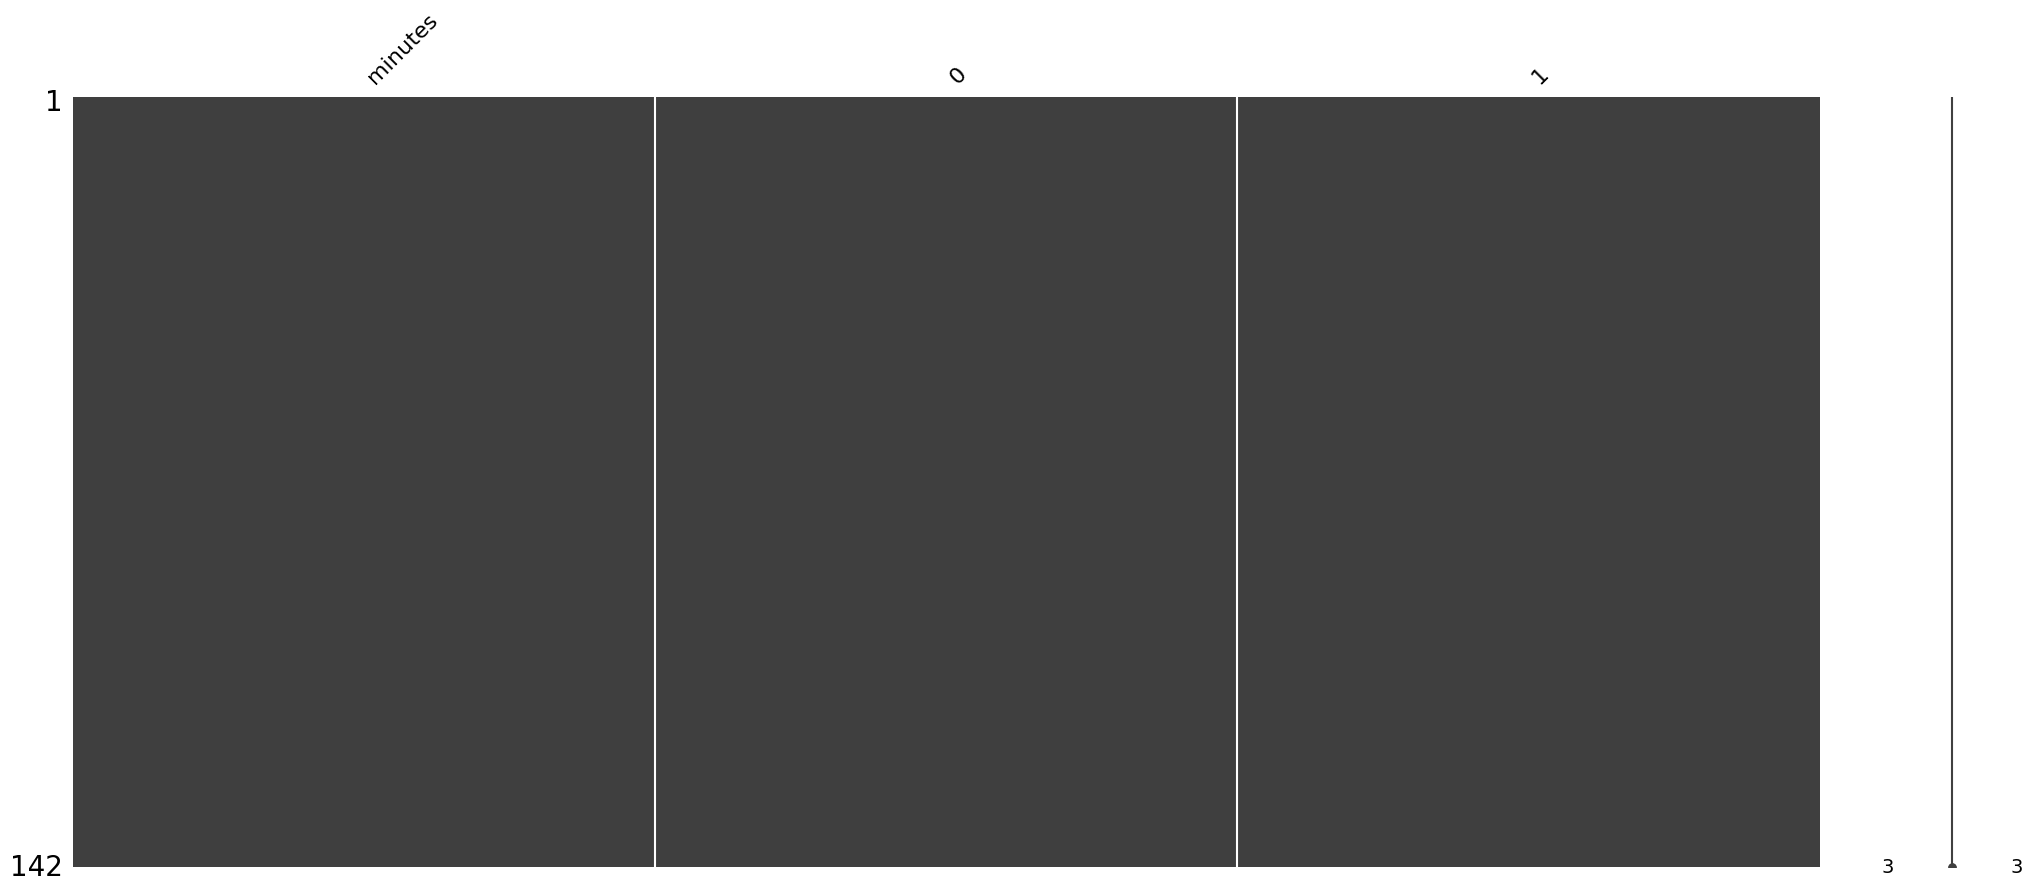

In [31]:
# Norte
#------------ A ---------------------------------
dic = {}
for j, h in enumerate (depth_layer):
    ft = vriemman(v_split, ws_split,depth, h, lat, lat_max_bd, lon,lon_mean_bd, inout='in')
    dic.update({j:ft})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    ft = vriemman(v_split, ws_split,depth, h, lat, lat_max_bd, lon,lon_max_bd, inout='in')
    dic.update({n_capas+j:ft})
    
df_norte = pd.DataFrame(dic)
df_norte.insert(loc= 0, column = 'minutes', value = minutes)

# # df_norte
# # df_norte[1] = df_norte[2]+0.0001
# df_norte[0] = df_norte[1]+0.0001

# df_norte[20] = df_norte[22]
# df_norte[19] = df_norte[21]
msno.matrix(df_norte)

In [46]:
df_norte.head(4)

,minutes,0,1
Fecha,,,
2021-10-28 00:00:00,0.0,-0.183829,-0.155336
2021-10-28 03:00:00,180.0,-0.655874,-0.625795
2021-10-28 06:00:00,360.0,-0.615352,-0.594878
2021-10-28 09:00:00,540.0,-0.310147,-0.298693


In [45]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'north_boundary.bct'
np.savetxt(path+'/'+name_file, df_norte.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

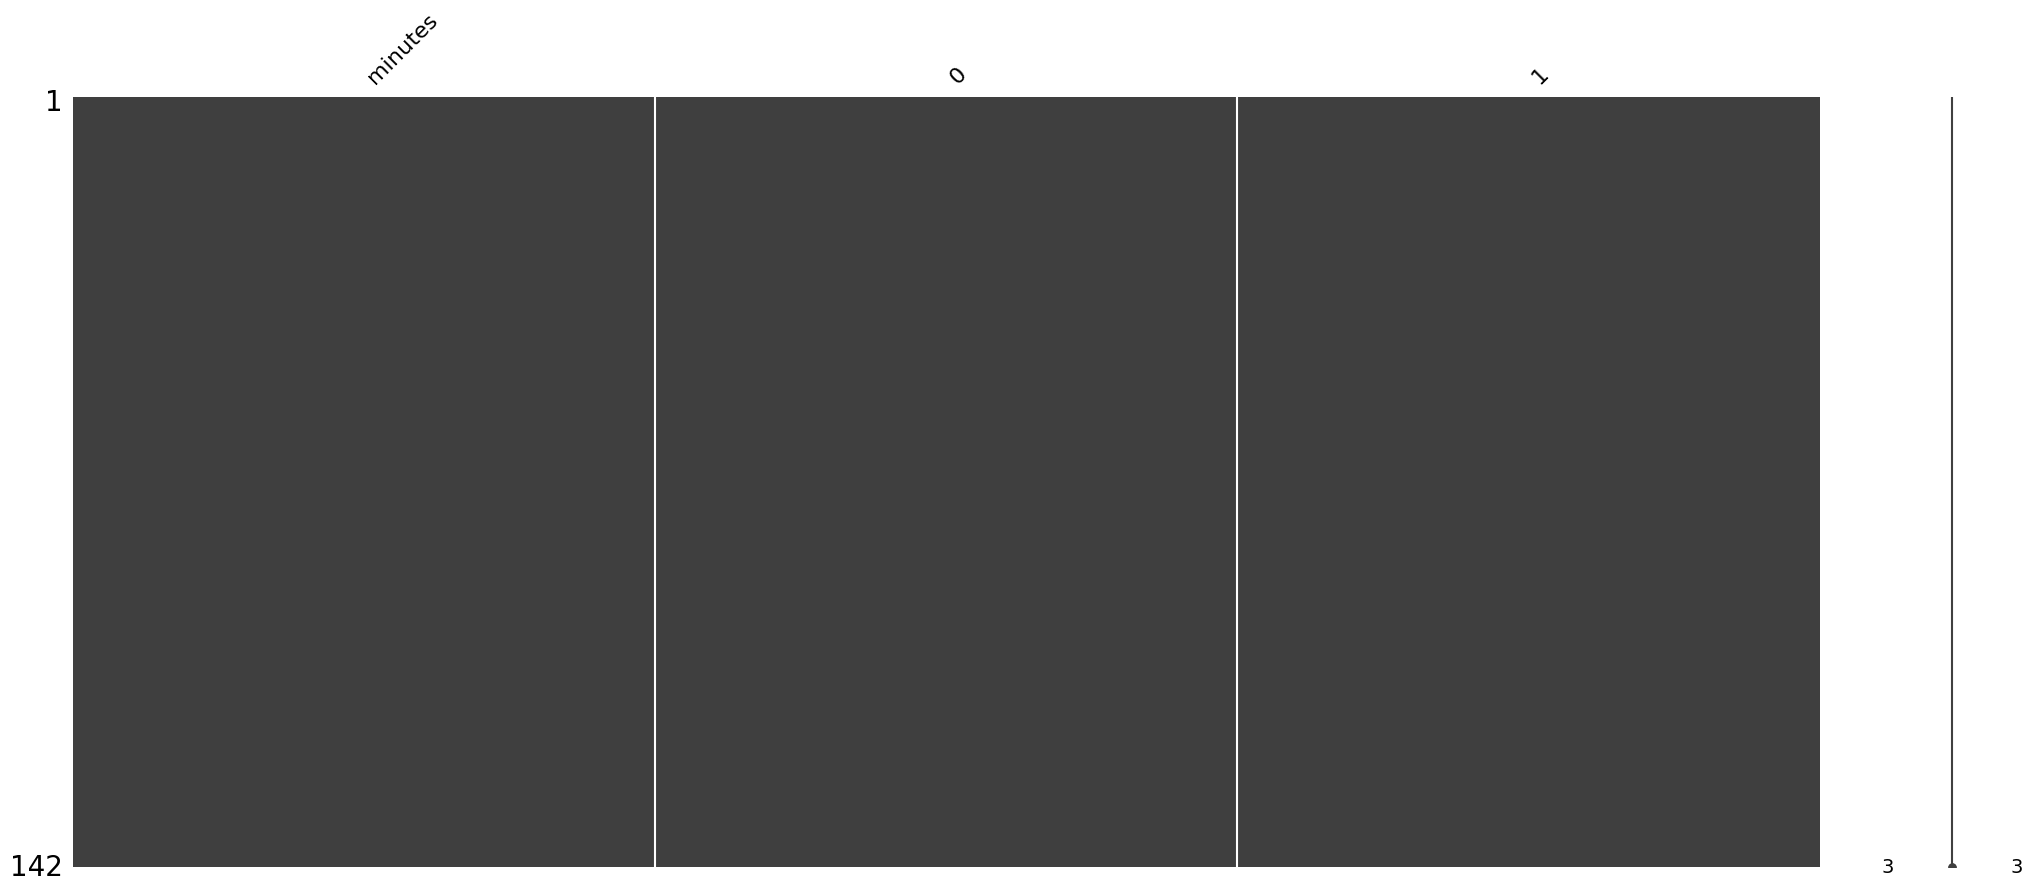

In [27]:
# Sur
#------------ A ---------------------------------
dic = {}
for j, h in enumerate (depth_layer):
    ft = vriemman(v_split, ws_split,depth, h, lat, lat_min_bd, lon,lon_min_bd,inout='in')
    dic.update({j:ft})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    ft = vriemman(v_split, ws_split,depth, h, lat, lat_min_bd, lon,lon_mean_bd,inout='in')
    dic.update({n_capas+j:ft})
    
df_sur = pd.DataFrame(dic)
df_sur.insert(loc= 0, column = 'minutes', value = minutes)
# df_sur[1] = df_sur[2]+0.0001
# df_sur[0] = df_sur[3]+0.0001
# df_sur[21] = df_sur[22]-0.0001
# df_sur[20] = df_sur[21] -0.0001
# df_sur[19] = df_sur[20] +0.0001
msno.matrix(df_sur)

In [28]:
df_sur.head(5)

,minutes,0,1
0,0.0,-0.542997,-0.561014
1,180.0,-0.573391,-0.595287
2,360.0,-0.561082,-0.579258
3,540.0,-0.500866,-0.526159
4,720.0,-0.442900,-0.459546


In [29]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'south_boundary.bct'
np.savetxt(path+'/'+name_file, df_sur.values, delimiter=' ', fmt = "%+15.7e")

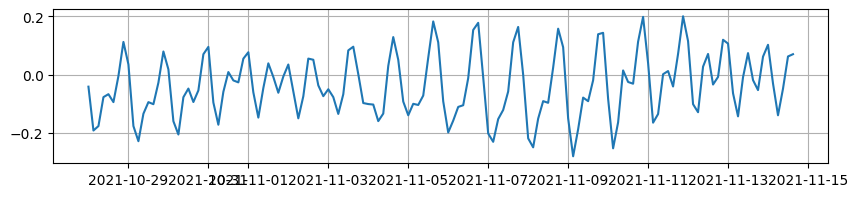

In [53]:
fig, ax = plt.subplots(figsize = (10,2))
ax.plot(time_d3d, ws)
ax.grid()

## Constituten properties

In [45]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data_prop = Dataset(path+'\Hycom_oct21_nov15_2021_6_temp_sal_2.nc','r')

salt = np.array(data_prop.variables['salinity'][:])
salt[salt==-30000] = np.nan
temp = np.array(data_prop.variables['water_temp'][:])
temp[temp==-30000] = np.nan


In [46]:
print(data_prop.variables)

{'latitude': <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (25,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (7,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: hours since 2000-01-01 00:00:00
    time_origin: 2000-01-01 00:00:00
    calendar: gregorian
unlimited dimensions: 
current shape = (200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'depth': <class 'netCDF4._netCDF4.Variable'>
float64 depth(depth)
    units: m
unlimited dimensions: 
current shape = (19,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'water_temp': <class 'netCDF4._netCDF4.Variable'>
float64 water_temp(time, depth, latitude, longitude)
    units: degC

In [47]:
def constituten(c, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd):
    """
    ------------input------------------------
    c: arreglo de la propiedad constitutiva (temp / sal) 
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    
    ------------output----------------------------
    constituen: serie de la propiedad constitutiva a la profundida deseada
    
    """
    c= c[:,np.where(depth_s==depth_bd)[0][0], np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    return c

In [48]:
# Time split 
salt_split = salt[ind_ini_fin[0]:ind_ini_fin[1],:,:]

temp_split = temp[ind_ini_fin[0]:ind_ini_fin[1],:,:]

<AxesSubplot:>

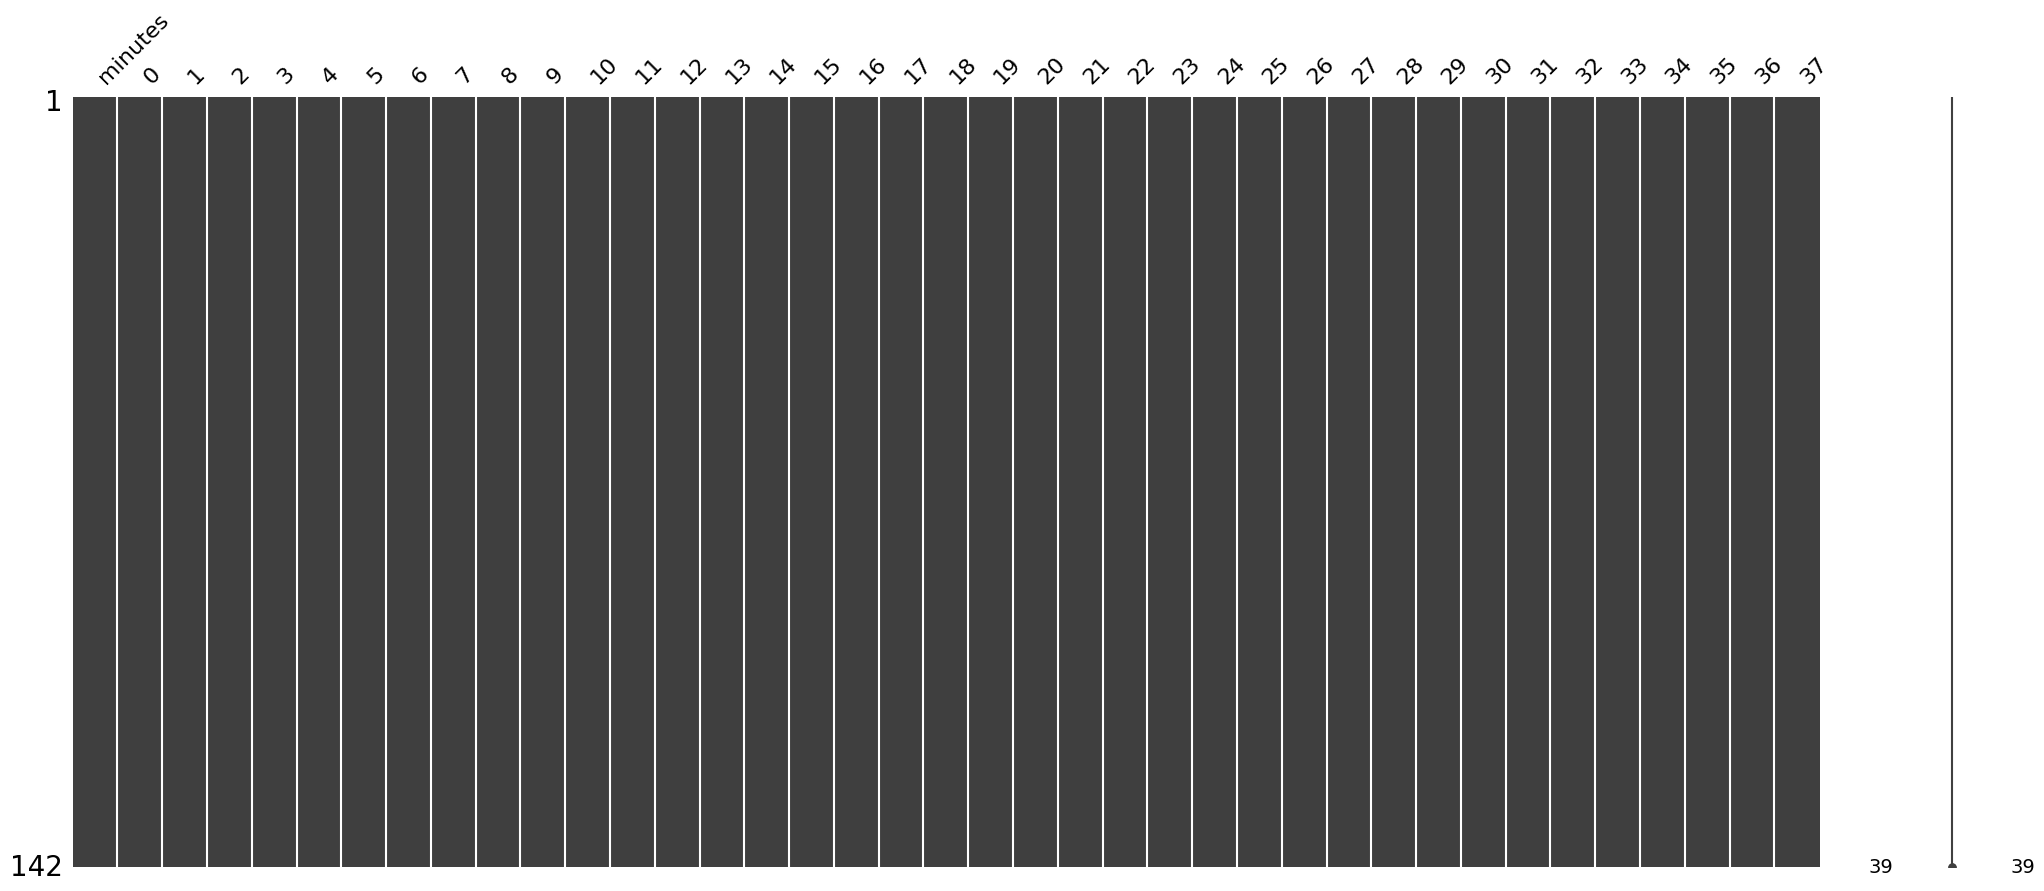

In [49]:
# Oeste
#------------ A ---------------------------------
dic_sal = {}
for j, h in enumerate (depth_layer):
    # print(h)
    c = constituten(salt_split, depth, h, lat, lat_mean_bd, lon,lon_min_bd)
    # print (j,h ,c[1])
    dic_sal.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_max_bd, lon,lon_min_bd)
    dic_sal.update({n_capas+j:c})
    
df_sal_oeste = pd.DataFrame(dic_sal)
df_sal_oeste.insert(loc= 0, column = 'minutes', value = minutes)
df_sal_oeste[1] = df_sal_oeste[2]-0.1
df_sal_oeste[0] = df_sal_oeste[1]-0.1
df_sal_oeste[20] = df_sal_oeste[21]-0.1
df_sal_oeste[19] = df_sal_oeste[20]-0.1
msno.matrix(df_sal_oeste)

In [50]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_west_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_oeste.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

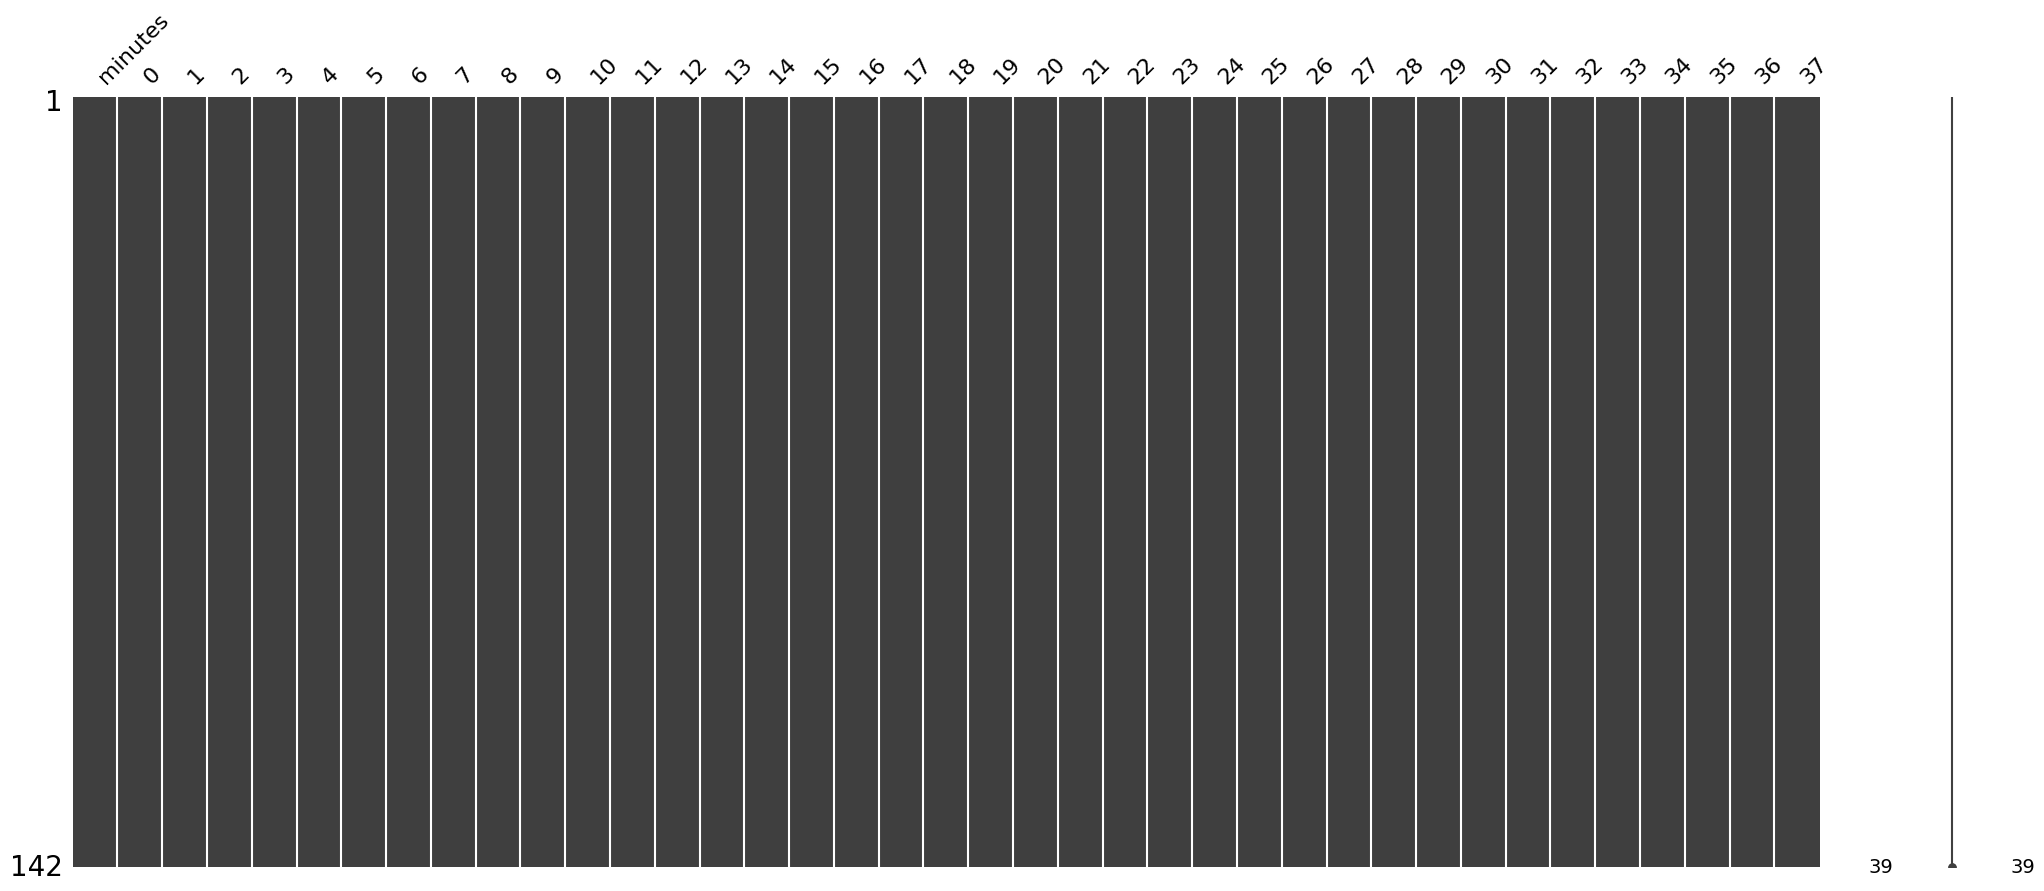

In [51]:
# Oeste
#------------ A ---------------------------------
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_mean_bd, lon,lon_min_bd)
    dic_temp.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_max_bd, lon,lon_min_bd)
    dic_temp.update({n_capas+j:c})
    
df_temp_oeste = pd.DataFrame(dic_temp)
df_temp_oeste.insert(loc= 0, column = 'minutes', value = minutes)
df_temp_oeste[1] = df_temp_oeste[2]-0.1
df_temp_oeste[0] = df_temp_oeste[1]-0.1
df_temp_oeste[20] = df_temp_oeste[21]-0.1
df_temp_oeste[19] = df_temp_oeste[20]-0.1
msno.matrix(df_temp_oeste)

In [52]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_west_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_oeste.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

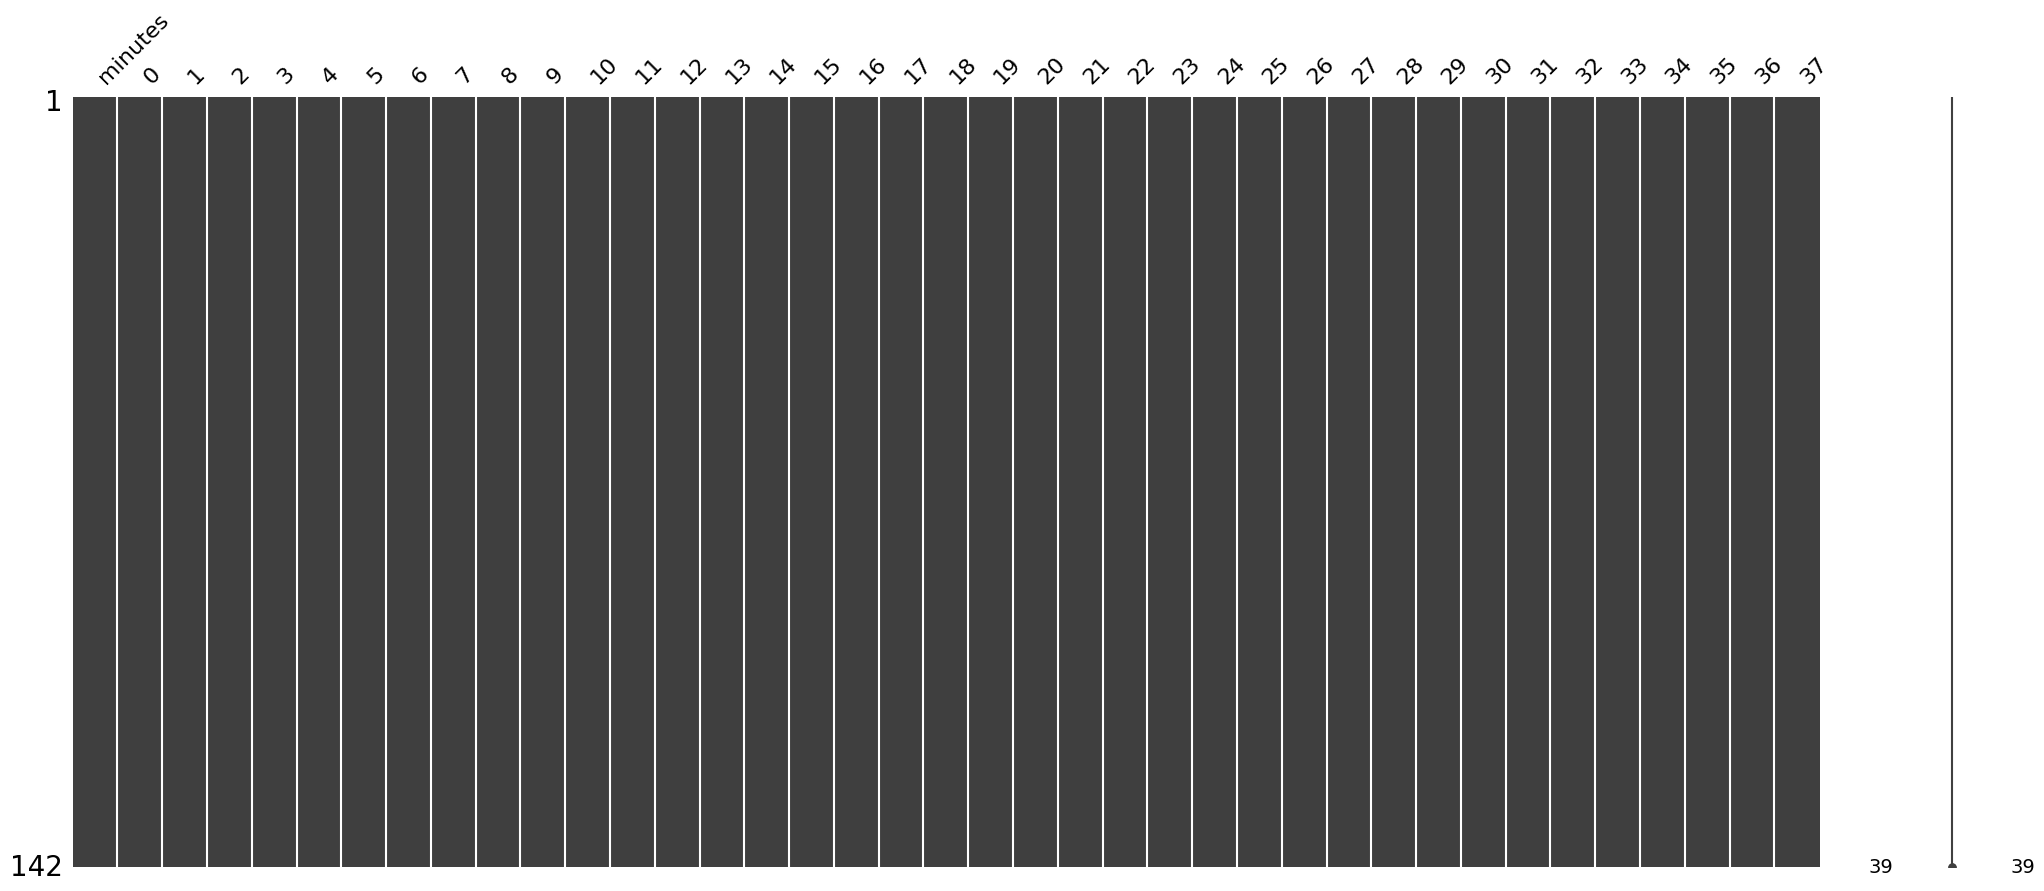

In [53]:
# Este
#------------ A ---------------------------------
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_max_bd, lon,lon_max_bd)
    dic_sal.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_mean_bd, lon,lon_max_bd)
    dic_sal.update({n_capas+j:c})
    
df_sal_este = pd.DataFrame(dic_sal)
df_sal_este.insert(loc= 0, column = 'minutes', value = minutes)

df_sal_este[1] = df_sal_este[2]-0.1
df_sal_este[0] = df_sal_este[1]-0.1
df_sal_este[20] = df_sal_este[21]-0.1
df_sal_este[19] = df_sal_este[20]-0.1
msno.matrix(df_sal_este)

In [54]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_est_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_este.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

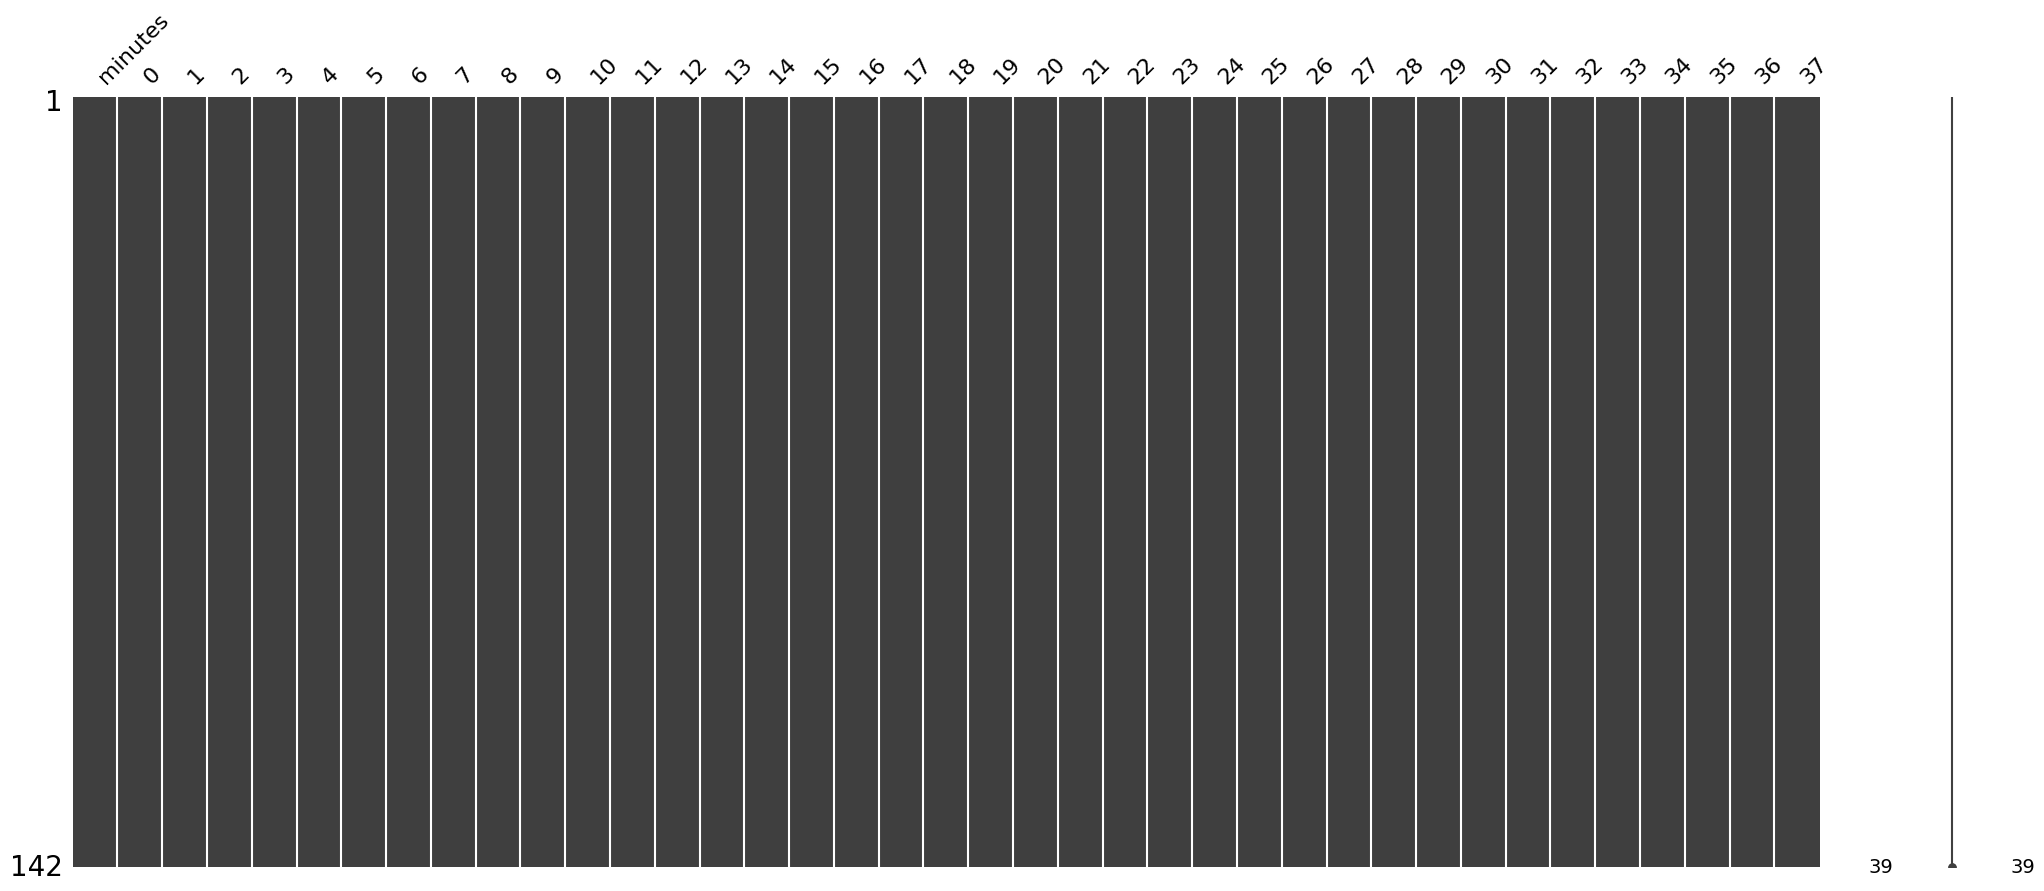

In [55]:
# Este
#------------ A ---------------------------------
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_max_bd, lon,lon_max_bd)
    dic_temp.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_mean_bd, lon,lon_max_bd)
    dic_temp.update({n_capas+j:c})
    
df_temp_este = pd.DataFrame(dic_temp)
df_temp_este.insert(loc= 0, column = 'minutes', value = minutes)

df_temp_este[1] = df_temp_este[2]-0.1
df_temp_este[0] = df_temp_este[1]-0.1
df_temp_este[20] = df_temp_este[21]-0.1
df_temp_este[19] = df_temp_este[20]-0.1
msno.matrix(df_temp_este)

In [56]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_est_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_este.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

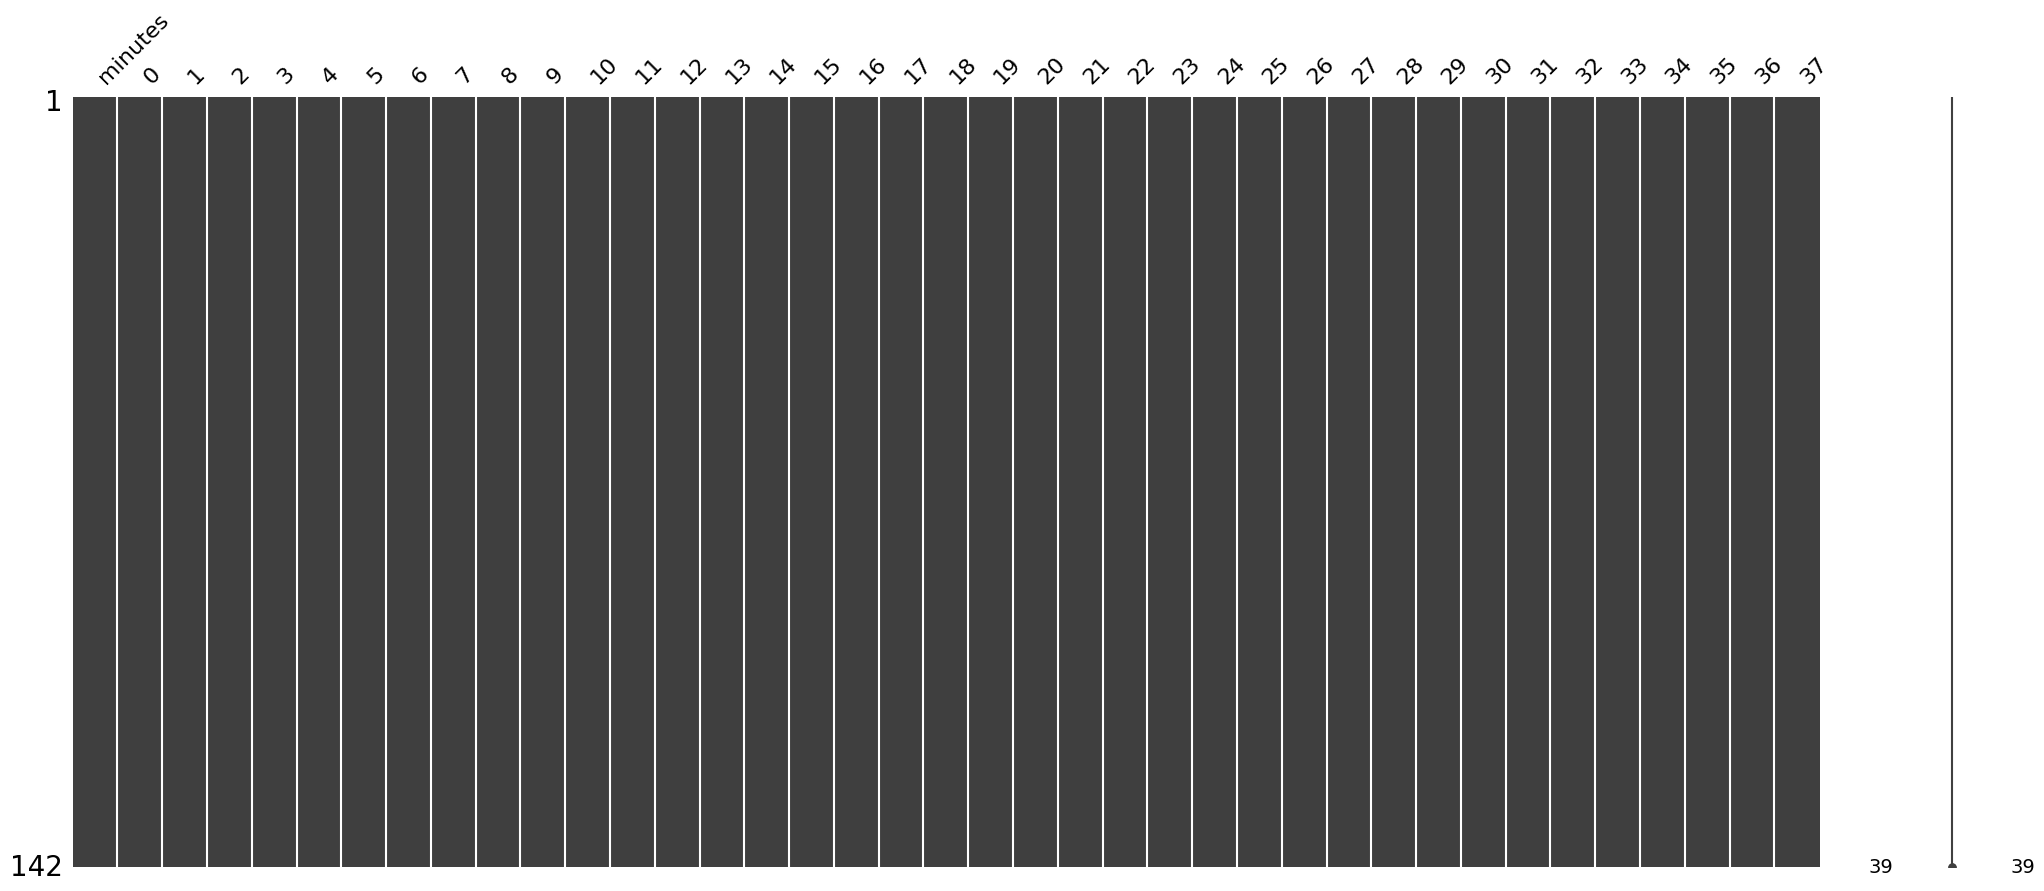

In [57]:
# Norte
#------------ A ---------------------------------
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_max_bd, lon,lon_mean_bd)
    dic_sal.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_max_bd, lon,lon_max_bd)
    dic_sal.update({n_capas+j:c})
    
df_sal_norte = pd.DataFrame(dic_sal)
df_sal_norte.insert(loc= 0, column = 'minutes', value = minutes)

df_sal_norte[1] = df_sal_norte[2]-0.1
df_sal_norte[0] = df_sal_norte[1]-0.1
df_sal_norte[20] = df_sal_norte[21]-0.1
df_sal_norte[19] = df_sal_norte[20]-0.1
msno.matrix(df_sal_norte)

In [58]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_north_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_norte.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

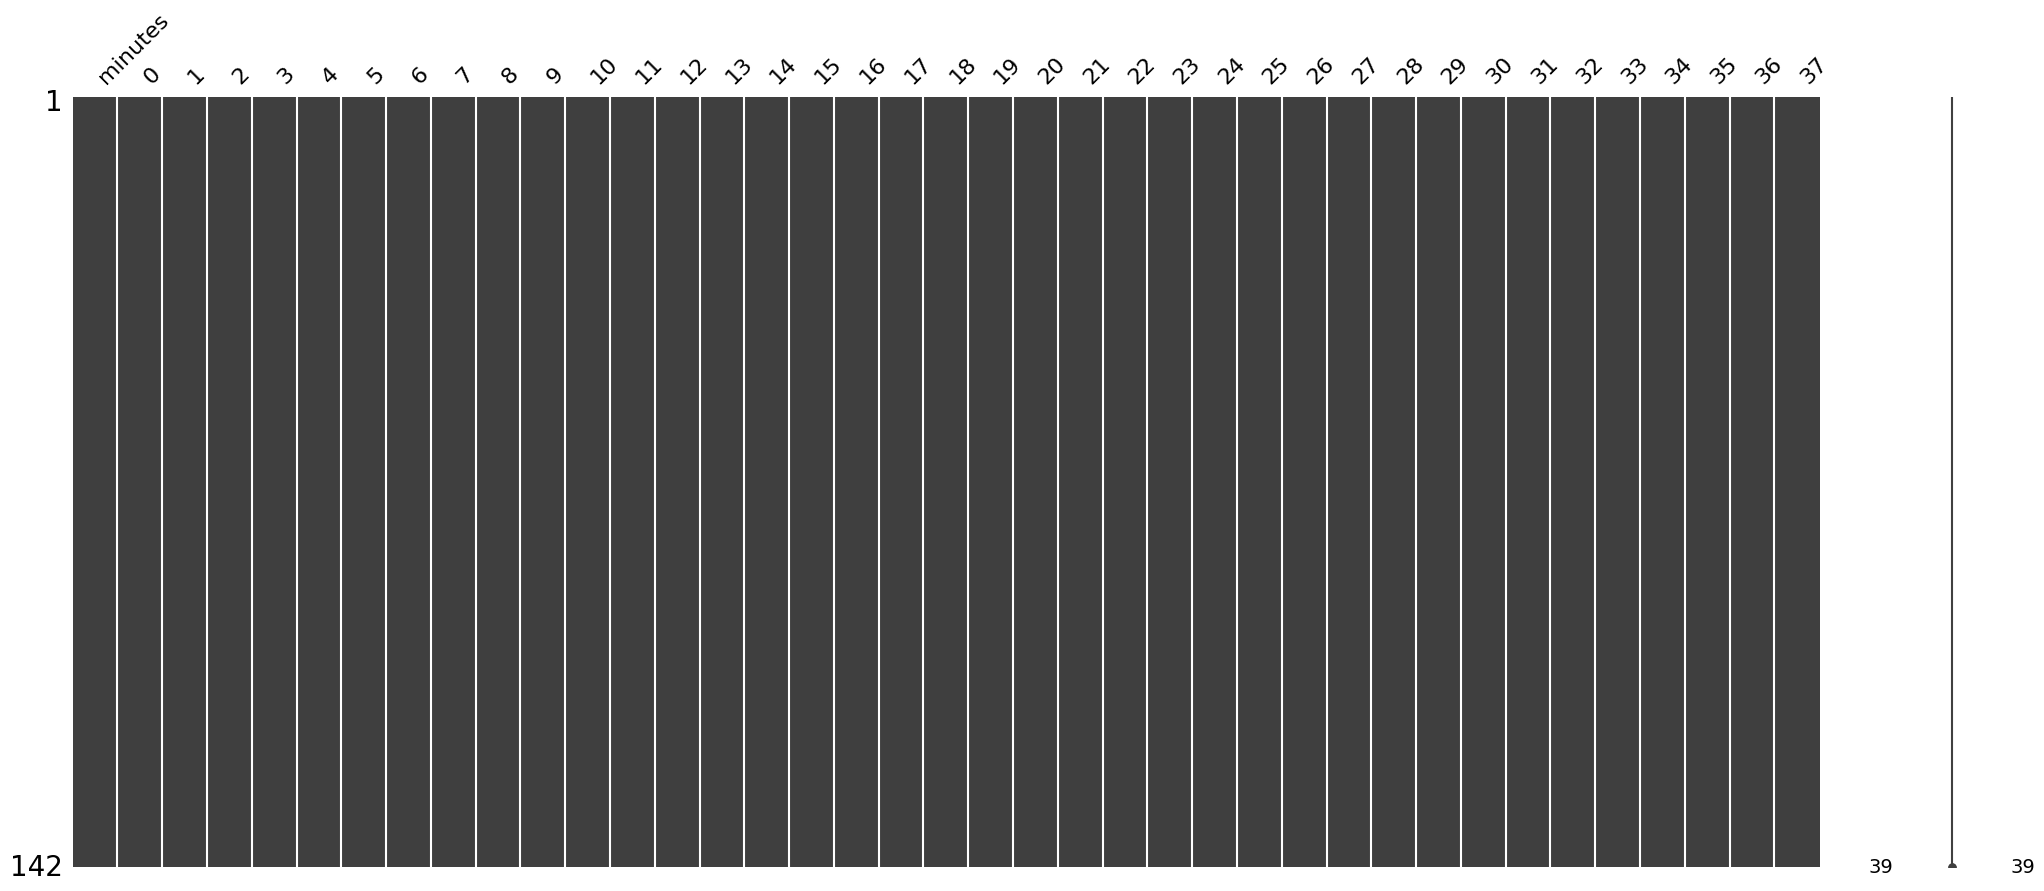

In [59]:
# Norte
#------------------------------------ A ---------------------------------
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_max_bd, lon,lon_mean_bd)
    dic_temp.update({j:c})


#------------------------------------ B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_max_bd, lon,lon_max_bd)
    dic_temp.update({n_capas+j:c})
    
df_temp_norte = pd.DataFrame(dic_temp)
df_temp_norte.insert(loc= 0, column = 'minutes', value = minutes)

df_temp_norte[1] = df_temp_norte[2]-0.1
df_temp_norte[0] = df_temp_norte[1]-0.1
df_temp_norte[20] = df_temp_norte[21]-0.1
df_temp_norte[19] = df_temp_norte[20]-0.1
msno.matrix(df_temp_norte)

In [60]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_north_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_norte.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

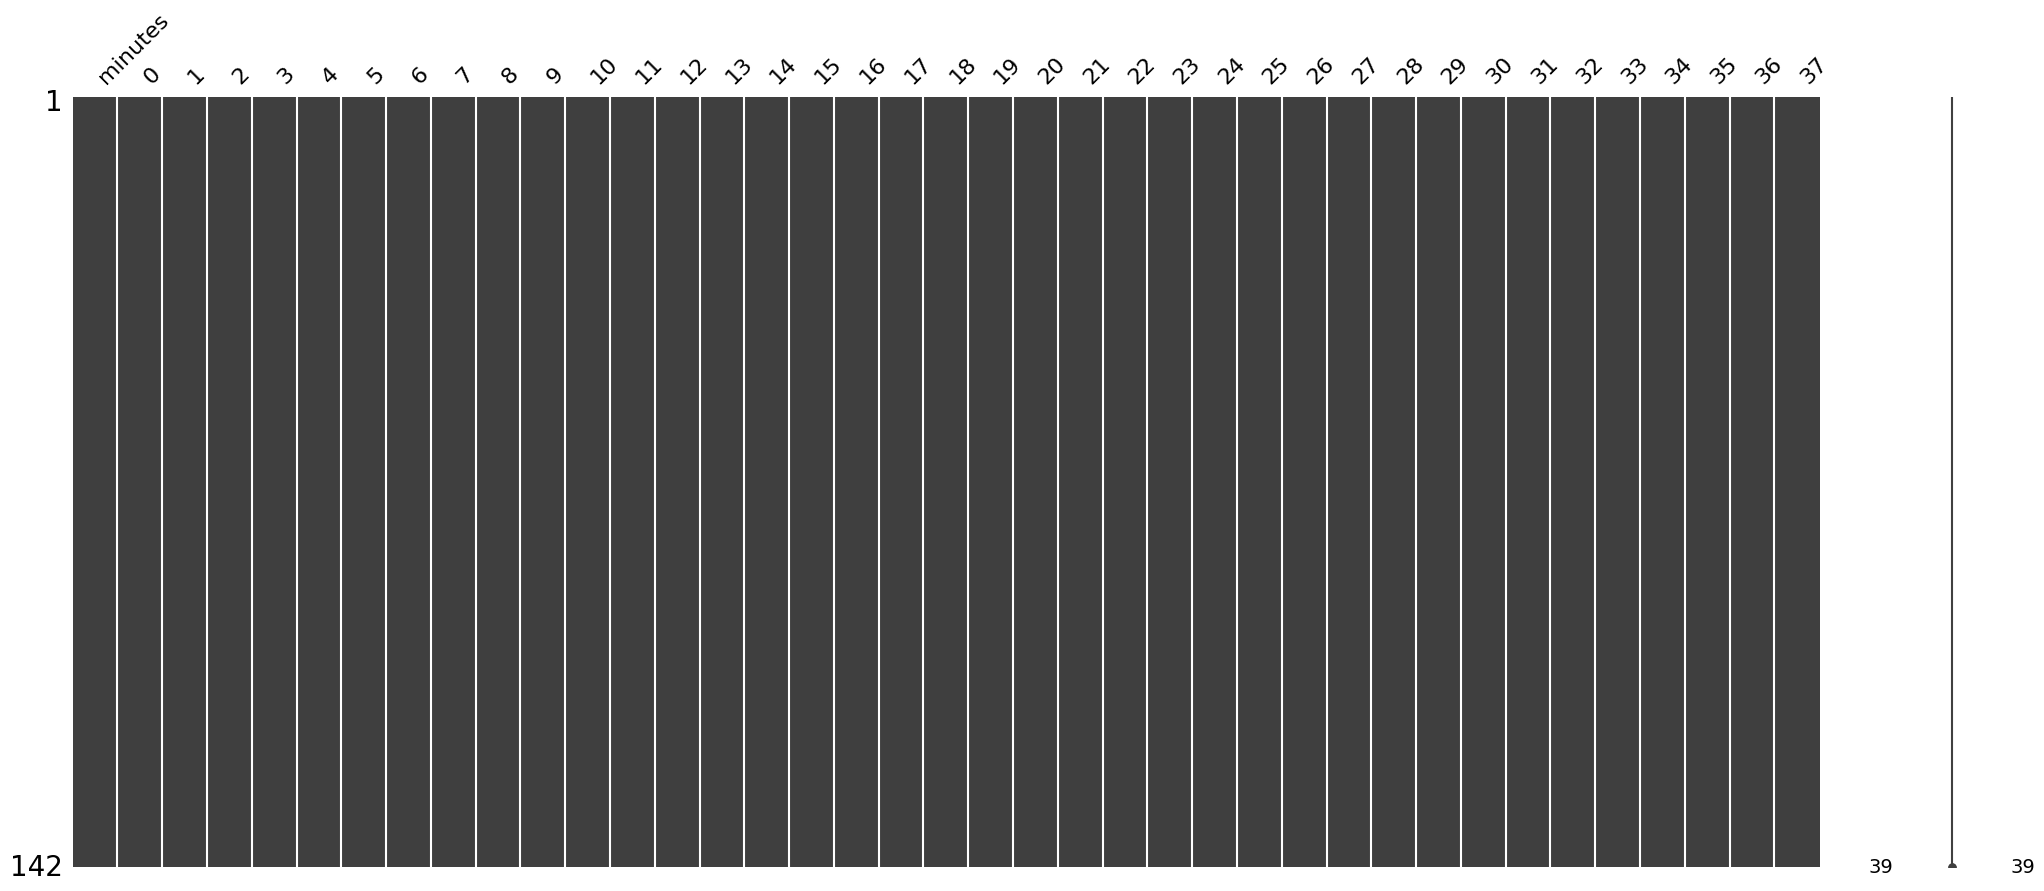

In [61]:
# Sur
#------------------------------- A ---------------------------------
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_min_bd, lon,lon_min_bd)
    dic_sal.update({j:c})


#------------------------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_min_bd, lon,lon_mean_bd)
    dic_sal.update({n_capas+j:c})
    
df_sal_sur = pd.DataFrame(dic_sal)
df_sal_sur.insert(loc= 0, column = 'minutes', value = minutes)

df_sal_sur[1] = df_sal_sur[2]-0.1
df_sal_sur[0] = df_sal_sur[1]-0.1
df_sal_sur[21] = df_sal_sur[22]-0.1
df_sal_sur[20] = df_sal_sur[21]-0.1
df_sal_sur[19] = df_sal_sur[20]-0.1
msno.matrix(df_sal_sur)

In [62]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_south_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_sur.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

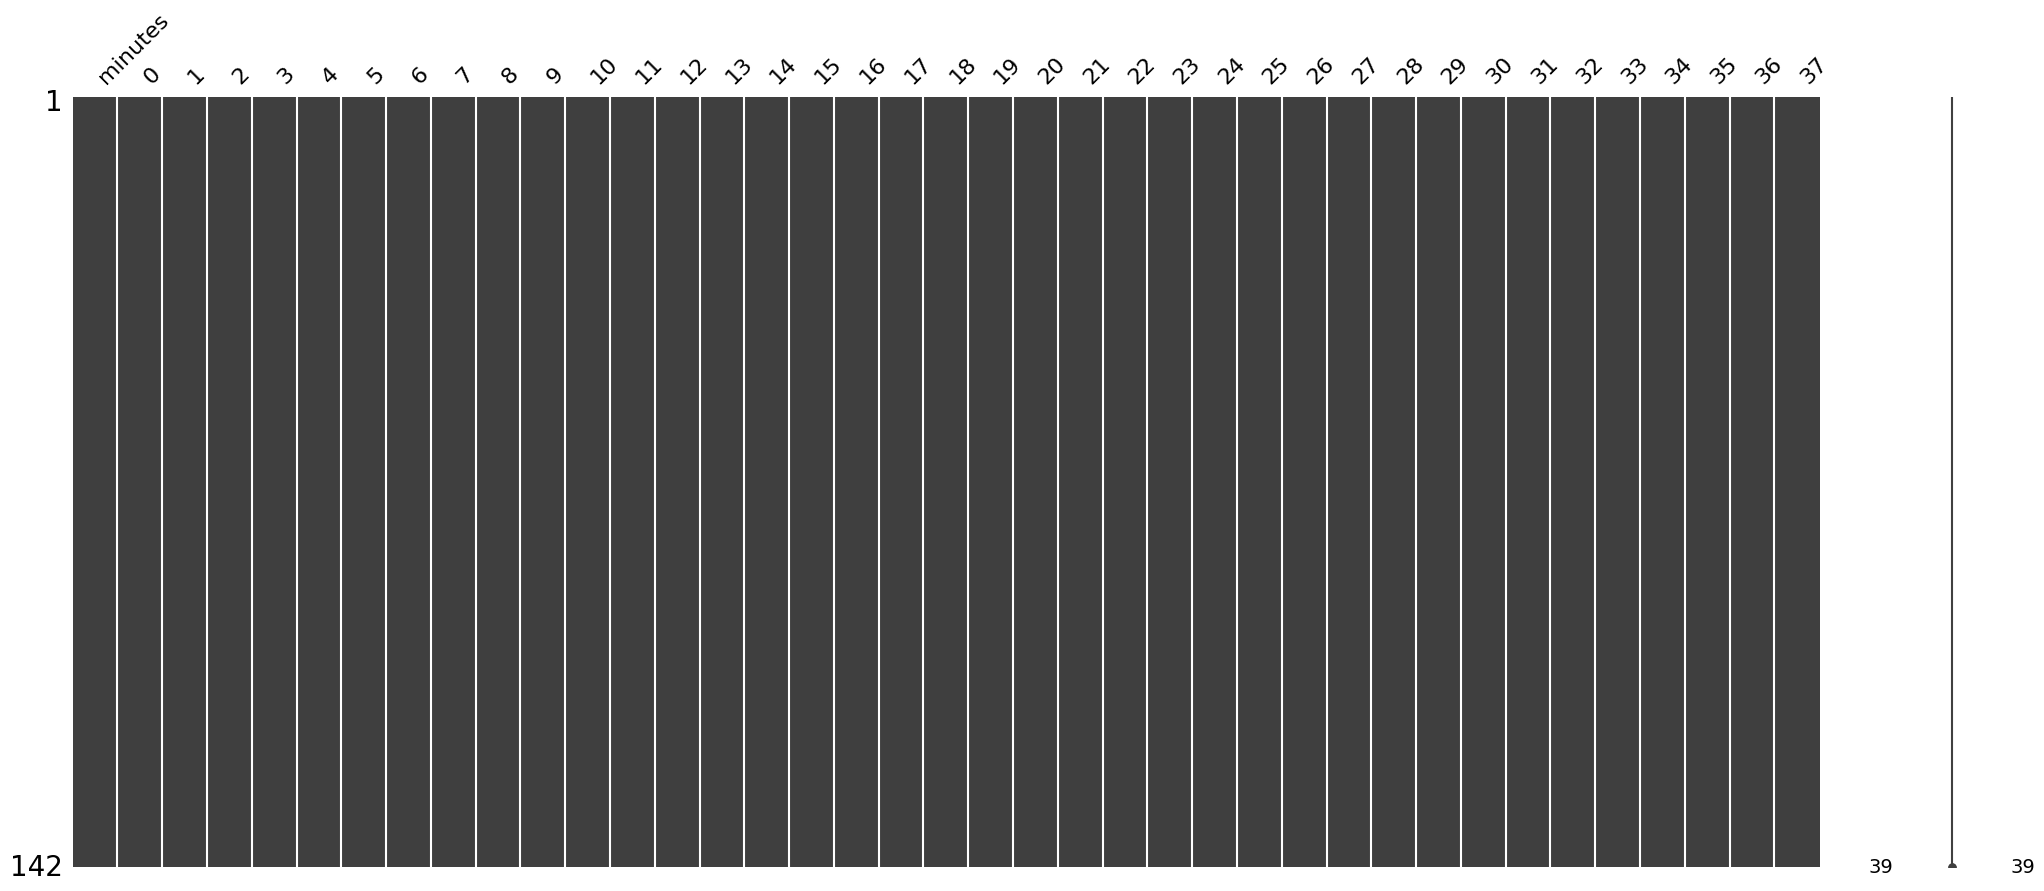

In [63]:
# Sur
#------------ A ---------------------------------
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_min_bd, lon,lon_min_bd)
    dic_temp.update({j:c})


#------------- B -----------------------------------
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_min_bd, lon,lon_mean_bd)
    dic_temp.update({n_capas+j:c})
    
df_temp_sur = pd.DataFrame(dic_temp)
df_temp_sur.insert(loc= 0, column = 'minutes', value = minutes)

df_temp_sur[1] = df_temp_sur[2]-0.1
df_temp_sur[0] = df_temp_sur[1]-0.1
df_temp_sur[21] = df_temp_sur[22]-0.1
df_temp_sur[20] = df_temp_sur[21]-0.1
df_temp_sur[19] = df_temp_sur[20]-0.1
msno.matrix(df_temp_sur)

In [64]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_south_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_sur.values, delimiter=' ', fmt = "%+15.7e")

# Physical parameters (Wind)

In [85]:
data = Dataset('data_wind_2021_oct_nov.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (3,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (3,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00017696378961697313
     add_offset: -4.378664596668559
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind com

In [86]:
# Extraer variables
lat_wind = np.array(data.variables['latitude'][:])
lon_wind = np.array(data.variables['longitude'][:])
nctime_wind = np.array(data.variables['time'][:])
t_unit_wind = data.variables['time'].units
t_cal_wind = data.variables['time'].calendar
time_wind = num2date(nctime_wind,units=t_unit_wind,calendar=t_cal_wind)#Date time
u10_wind = np.array(data.variables['u10'][:])
v10_wind = np.array(data.variables['v10'][:])

# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wind])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time_wind = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time_wind

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

In [87]:
# Función para determinar 
def angulo_norte(x,y):
    if x > 0 and y > 0:
        theta = 90 - (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y > 0:
        theta = 270 + (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y < 0:
        theta = 270 - (np.arctan(abs(y/x))*(180/np.pi))
    else:
        theta = 90 + (np.arctan(abs(y/x))*(180/np.pi))
    return theta

In [88]:
date_ini = datetime(2021,10,28,0) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time_wind==date_ini)|(time_wind==date_fin))[0]
time_d3d_wind = time_wind[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wind.shape)

[ 653 1077]
(424,)


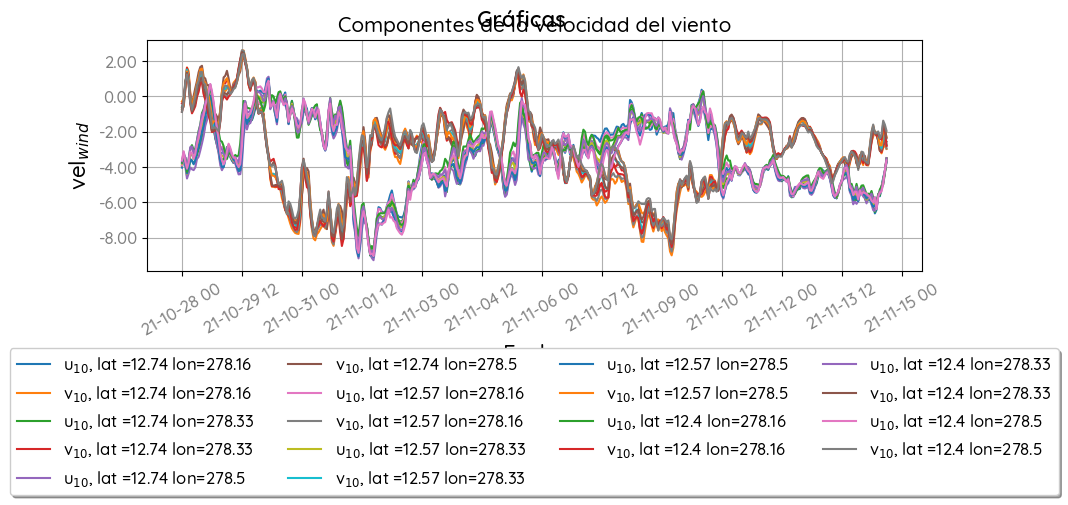

In [89]:
hourticks = ((time_d3d_wind[-1]-time_d3d_wind[0]).days*24 +(time_d3d_wind[-1]-time_d3d_wind[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wind[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,3))
for i in range(len(lat_wind)):
    for j in range(len(lon_wind)):
        ax.plot(time_d3d_wind, u10_wind[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'u$_{10}$, lat ='+str(lat_wind[i])+ ' lon='+str(lon_wind[j]))
        ax.plot(time_d3d_wind, v10_wind[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wind[i])+ ' lon='+str(lon_wind[j]))

# ax.plot(time_d3d, ft_west_a, label = 'f$_t$_1', ms=5, color = 'k')
# ax.plot(time_d3d, ft_south_b, label = 'f$_t$_2', ms=5)
# ax.plot(time_d3d, ft_east_b, label = 'f$_t$_3', ms=5, color = 'c')
# ax.plot(time_d3d, ft_north_a, label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('vel$_{wind}$',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Componentes de la velocidad del viento',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [90]:
x_wind_utm = np.zeros(shape=(lon_wind.shape))
y_wind_utm = np.zeros(shape=(lat_wind.shape))
m = 0 
for i, j in zip (lon_wind,lat_wind):
    x_wind_utm[m],y_wind_utm[m]= proj_ZONE17(i,j)
    m = m + 1

In [91]:
# Extraer componentes de la velocidad el viento para la fecha establecida y calcular la magnitud y direeción de los vientos.
vd3d_wind = v10_wind[ind_ini_fin[0]:ind_ini_fin[1],0,0]
ud3d_wind = u10_wind[ind_ini_fin[0]:ind_ini_fin[1],0,0]
Wind_magnitud = np.sqrt(vd3d_wind**2+ud3d_wind**2)
Wind_dir = np.array([angulo_norte(ud3d_wind[i],vd3d_wind[i]) for i in range (0, len(vd3d_wind))])
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
data_wind = {'minutes':minutes,'wind_speed':Wind_magnitud,'wind_dir':Wind_dir}
df_wind = pd.DataFrame(data = data_wind)

# path = r"G:\Mi unidad\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION"
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
file_name = 'data_wind.wnd'
np.savetxt(path+'/'+file_name, df_wind.values, delimiter='  ', fmt = "%.7f" ) 

In [92]:
df_wind

,minutes,wind_speed,wind_dir
0,0.0,4.049180,265.915220
1,60.0,3.485423,267.886213
2,120.0,3.502069,278.752773
3,180.0,4.670719,290.431165
4,240.0,4.277691,289.313816
...,...,...,...
419,25140.0,6.425852,241.765543
420,25200.0,6.118317,238.134747
421,25260.0,5.454701,237.665496
422,25320.0,5.063996,236.933457


# POSPROCESAMIENTO

In [10]:
path_d3d = r"G:\Mi unidad\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS\TEST7"
wl_mat = mat73.loadmat(path_d3d + '/water_level.mat')
dir_wl = wl_mat['data']
wl = dir_wl['Val']

In [22]:
wl.shape

(202, 207)

In [24]:
dir_wl['X'][1:,1:].shape

(202, 207)

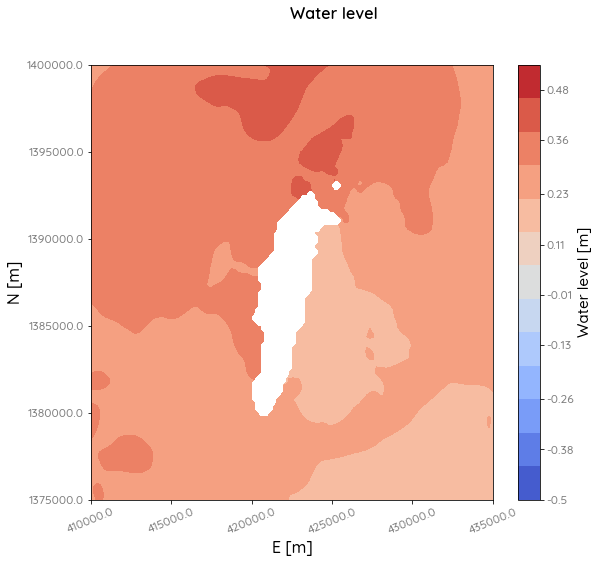

In [41]:
x = dir_wl['X'][1:,1:]
y = dir_wl['Y'][1:,1:]

fig, ax = plt.subplots(figsize = (9,8))
colormap = cm.Blues
colormap = cm.coolwarm
level_i = -0.5
level_f = 0.6
pc = ax.contourf(x, y, wl,levels = np.arange(level_i,level_f,0.08),cmap = colormap)
# pc = ax.contourf(x, y, wl,cmap = colormap)

cb=plt.colorbar(pc,ticks = [round(np.linspace(level_i,level_f,10)[i],2) for i in range(10)])
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
# ax.set_xlim([np.nanmin(x), np.nanmax(x)])
# ax.set_ylim([np.nanmin(y), np.nanmax(y)])
ax.set_xlim([410000, 435000])
ax.set_ylim([1375000, 1400000])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Water level [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
fig.suptitle("Water level", size = 16,fontproperties=prop2)     # Titulo de la figura
# ax.set_title('San Andres Island at'+str(time[197]),size = 16,fontproperties=prop1)
# ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9,label='Coast line')
# _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation =22.5)
plt.grid(False)
# plt.savefig('test_2_Prueba.jpg',dpi=800,bbox_inches='tight')